## QC and Fine Grain Clustering of NK Cells

In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(tidyr)
library(viridis)
library(stringr)
library(pheatmap)
library(presto)
library(pals)
library(harmony)
library(singlecellmethods)
library(lisi)
library(symphony)
source("/data/srlab/ik936/Foxxy/utils/utils.R")
source("/data/srlab/anathan/scripts/scseq_utils.R")
library(parallel)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite

Loading required package: Rcpp

Warning message:
“package ‘Rcpp’ was built under R version 4.1.3”
Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘pals’


The following objects are masked from ‘package:viridis’:

    cividis, inferno, magma, plasma, turbo, viridis


The following objects are masked from ‘package:viridisLite’:

    cividis, inferno, magma, plasma, turbo, viridis



Attaching package: ‘singlecellmethods’


The following object is masked from ‘package:SeuratObject’:

    rowMeans


The following object is masked from ‘package:base’:

    rowMeans



Attaching package: ‘symphony’


The fo

In [2]:
plot_clusters3 <- function(cluster_ids, labels, pt_size = 20, umap_use = umap_post,
                           do_labels = FALSE,
                           do_points = TRUE, do_density = FALSE, alpha_pt = 1, min_cluster_size = 20) {
    cluster_table <- table(cluster_ids)
    clusters_keep <- names(which(cluster_table > min_cluster_size))
    plt_df <- umap_use %>% data.frame() %>% cbind(cluster = factor(cluster_ids)) %>% cbind(cluster_label = labels)
    factor_levels <- plt_df %>% select(cluster_label, cluster) %>% unique() %>% arrange(as.numeric(cluster)) %>% pull(cluster_label)
    plt <- plt_df %>%
        dplyr::sample_frac(1L) %>%
        ggplot(aes(hUMAP1, hUMAP2, col = factor(cluster_label, levels = factor_levels), fill = factor(cluster_label, factor_levels)))
    if (do_points)
        plt <- plt + geom_point(alpha = alpha_pt, size = 0.5) + theme_classic()
    if (do_density)
        plt <- plt + geom_density_2d()


    plt <- plt +
     #   theme_tufte() +
#         theme(axis.line = element_line()) +
        guides(color = guide_legend(override.aes = list(size = 6))) +
#         scale_color_manual(values = sample(unique(singler.colors))) +
#         scale_color_manual(values = palette_use) +
        labs(x = "UMAP 1", y = "UMAP 2") +
        theme(plot.title = element_text(hjust = .5))

    if (do_labels)
        plt <- plt + ggrepel::geom_label_repel(data = data.table(plt_df)[, .(hUMAP1 = mean(hUMAP1), hUMAP2 = mean(hUMAP2)), by = .(cluster_label, cluster)], label.size = NA,
                                aes(label = cluster), color = "white", size = 5,  max.overlaps = 15) +
        guides(col = FALSE, fill = FALSE) +
#         scale_fill_manual(values = palette_use) +
        NULL
    return(plt)
}

plot_shuffled_features <- function(ab, umap, exprs, pct) {
    library(viridis)
    max.cutoff = quantile(exprs[ab,], pct)
    min.cutoff = quantile(exprs[ab,], 1-pct)
    
    tmp <- sapply(X = exprs[ab,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    umap_res_plot <- cbind(umap, tmp)
    return(ggplot(data = as.data.frame(umap_res_plot)[sample(nrow(umap_res_plot)),] , aes(x = V1, y = V2)) +
      geom_point(mapping = aes(color = tmp), size = 0.75) +
      scale_color_viridis(option = "inferno", end = pct) +
      theme_classic() +
      theme(plot.title = element_text(size = 15), legend.position = "none") +
      labs(title = ab, x = 'hUMAP1', y = 'hUMAP2', color = "Normalized Expression"))
}
                           fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 300)
}

## Read In Files

In [3]:
t_nk_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_norm_09092022.rds')
nk_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/NK_refmapped_RA_preqc_10252022.rds')
nk_norm <- t_nk_norm[, nk_meta$cell]
saveRDS(nk_norm, '/data/srlab/ssg34/SLE_kidney_v2/data/qcd/NK_refmapped_RA_preqc_norm_10252022.rds')

## QC Clustering

In [5]:
genes_exclude <- c(grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(nk_norm), value = TRUE), Seurat::cc.genes$s.genes, Seurat::cc.genes$g2m.genes) 

In [6]:
nuc_norm <- nk_norm[, nk_meta %>% filter(dataset == 'snRNAseq') %>% pull(cell)]

sc_norm <- nk_norm[, nk_meta %>% filter(dataset == 'scRNAseq') %>% pull(cell)]

nuc_meta <- nk_meta %>% filter(dataset == 'snRNAseq')

sc_meta <- nk_meta %>% filter(dataset == 'scRNAseq')

In [7]:
## Filtering for expressed genes
threshold_genes <- nuc_norm[rownames(nuc_norm[rowMeans(nuc_norm) >= .01, ]), ]

samples_25 <- nuc_meta %>% group_by(sample) %>% tally() %>% filter(n > 10) %>% pull(sample)

threshold_samples <- threshold_genes[, nuc_meta %>% filter(sample %in% samples_25) %>% pull(cell)]
 
## Variable gene selection — very inefficiently written, but essentially using VST to select most variable genes from samples with > 10 cells
var_genes_raw <- singlecellmethods::vargenes_vst(object = threshold_samples, groups = nuc_meta %>% filter(sample %in% samples_25) %>% pull(sample), topn = 500)

In [8]:
## Scale Data
nk_scaled_nuc <- nuc_norm[var_genes_raw[! var_genes_raw %in% genes_exclude], ] %>% scaleData
## PCA
nk_pca_res_nuc <- irlba::prcomp_irlba(t(nk_scaled_nuc), 20)
## UMAP
nk_umap_res_nuc <- uwot::umap(nk_pca_res_nuc$x[, 1:20], n_neighbors = 30L, metric = "euclidean", min_dist = .1)

use_weights



[1] FALSE


use_weights

use_weights



[1] FALSE


use_weights

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony 6/20

Harmony 7/20

Harmony 8/20

Harmony 9/20

Harmony 10/20

Harmony 11/20

Harmony 12/20

Harmony 13/20

Harmony 14/20

Harmony 15/20

Harmony 16/20

Harmony 17/20

Harmony 18/20

Harmony 19/20

Harmony 20/20



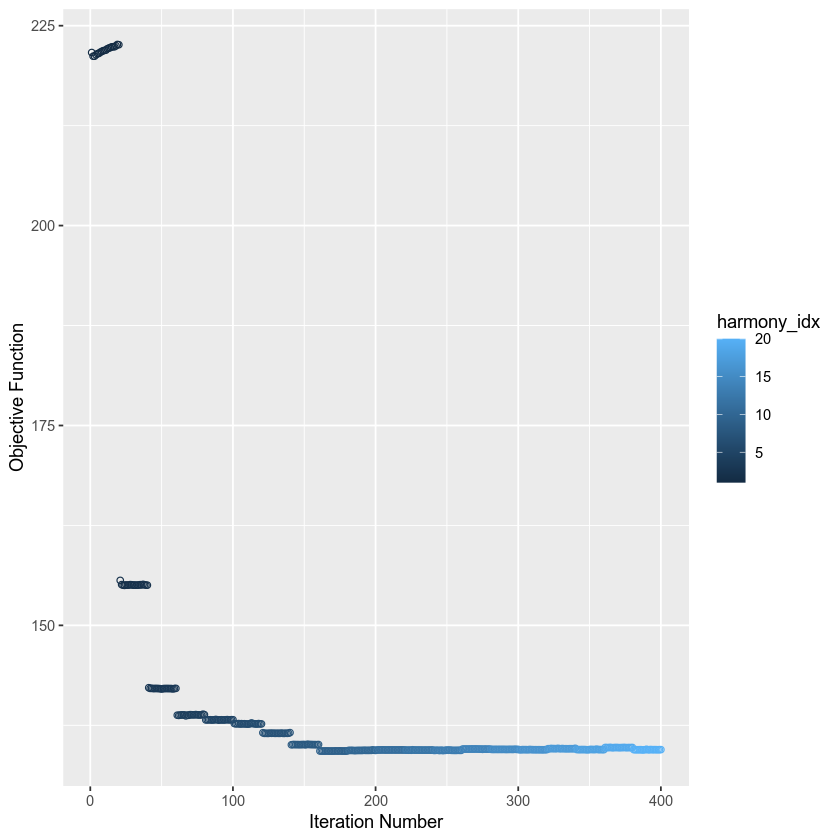

In [16]:
nk_harmony_nuc <- HarmonyMatrix(nk_pca_res_nuc$x[, 1:20], nuc_meta, 
                                     vars_use = c("sample", "processing.batch", "Site"), 
                        # lambda = 1, 
                        # tau = 0, 
                        epsilon.cluster = -Inf,
                        epsilon.harmony = -Inf,
                        max.iter.cluster = 20,
                        max.iter.harmony = 20,
                        plot_convergence = TRUE,
                        npcs = 20, do_pca = FALSE)

In [18]:
nk_humap_res_nuc <- uwot::umap(nk_harmony_nuc[, 1:20], n_neighbors = 30L, metric = "euclidean", min_dist = .1)

In [19]:
snn_ref <- BuildSNNSeurat(nk_harmony_nuc[,1:20], nn.eps = 0)

resolution_list <- c(2.0)
ids_ref_nuc <- Reduce(cbind, mclapply(resolution_list, function(res_use) {
    Seurat:::RunModularityClustering(SNN = snn_ref, modularity = 1,
        resolution = res_use, algorithm = 1, n.start = 20,
        n.iter = 20, random.seed = 100, print.output = FALSE,
        temp.file.location = NULL, edge.file.name = NULL)
}, mc.preschedule = FALSE, mc.cores = min(20, length(resolution_list)))) 

In [20]:
MYL <- c("AIF1", "LYZ", "FCGR3A", "CD14")

B <- c("MS4A1", "IGHG1", "MZB1")

T <- c("CD2", "CD3D")

EC <- c("ENG", "EGFL7", "EMCN")

IC <- c("ATP6V0D2", "ATP6V1G3", "SLC26A7")

PC_DCT_CNT <- c("CALB1", "FXYD4", "AQP2")

ATL_TAL <- c("SLC12A1", "SFRP1", "EGF")

FIB <- c("COL1A2", "COL1A1", "CCDC80")

POD <- c("PTGDS", "PODXL", "NPHS2")

PT1 <- c("SLC13A3", "SLC34A1", "LRP2")

MAST <- c("TPSB2", "TPSAB1", "CPA3")

pDC <- c('IL3RA', 'JCHAIN', 'NRP1')

In [ ]:
nuc_meta <-nuc_meta %>% mutate(Myeloid = colMeans(nuc_norm[rownames(nuc_norm) %in% MYL, ]),
                                        T = colMeans(nuc_norm[rownames(nuc_norm) %in% T, ]), 
                                        B = colMeans(nuc_norm[rownames(nuc_norm) %in% B, ]),
                                        EC = colMeans(nuc_norm[rownames(nuc_norm) %in% EC, ]),
                                        IC = colMeans(nuc_norm[rownames(nuc_norm) %in% IC, ]),
                                        PC = colMeans(nuc_norm[rownames(nuc_norm) %in% PC_DCT_CNT, ]),
                                        ATL = colMeans(nuc_norm[rownames(nuc_norm) %in% ATL_TAL, ]),
                                        Fib = colMeans(nuc_norm[rownames(nuc_norm) %in% FIB, ]),
                                        Pod = colMeans(nuc_norm[rownames(nuc_norm) %in% POD, ]),
                                        PT = colMeans(nuc_norm[rownames(nuc_norm) %in% PT1, ]),
                                        qc_cluster = ids_ref_nuc)

In [23]:
ids_ref_nuc %>% range()

[1] 0 6

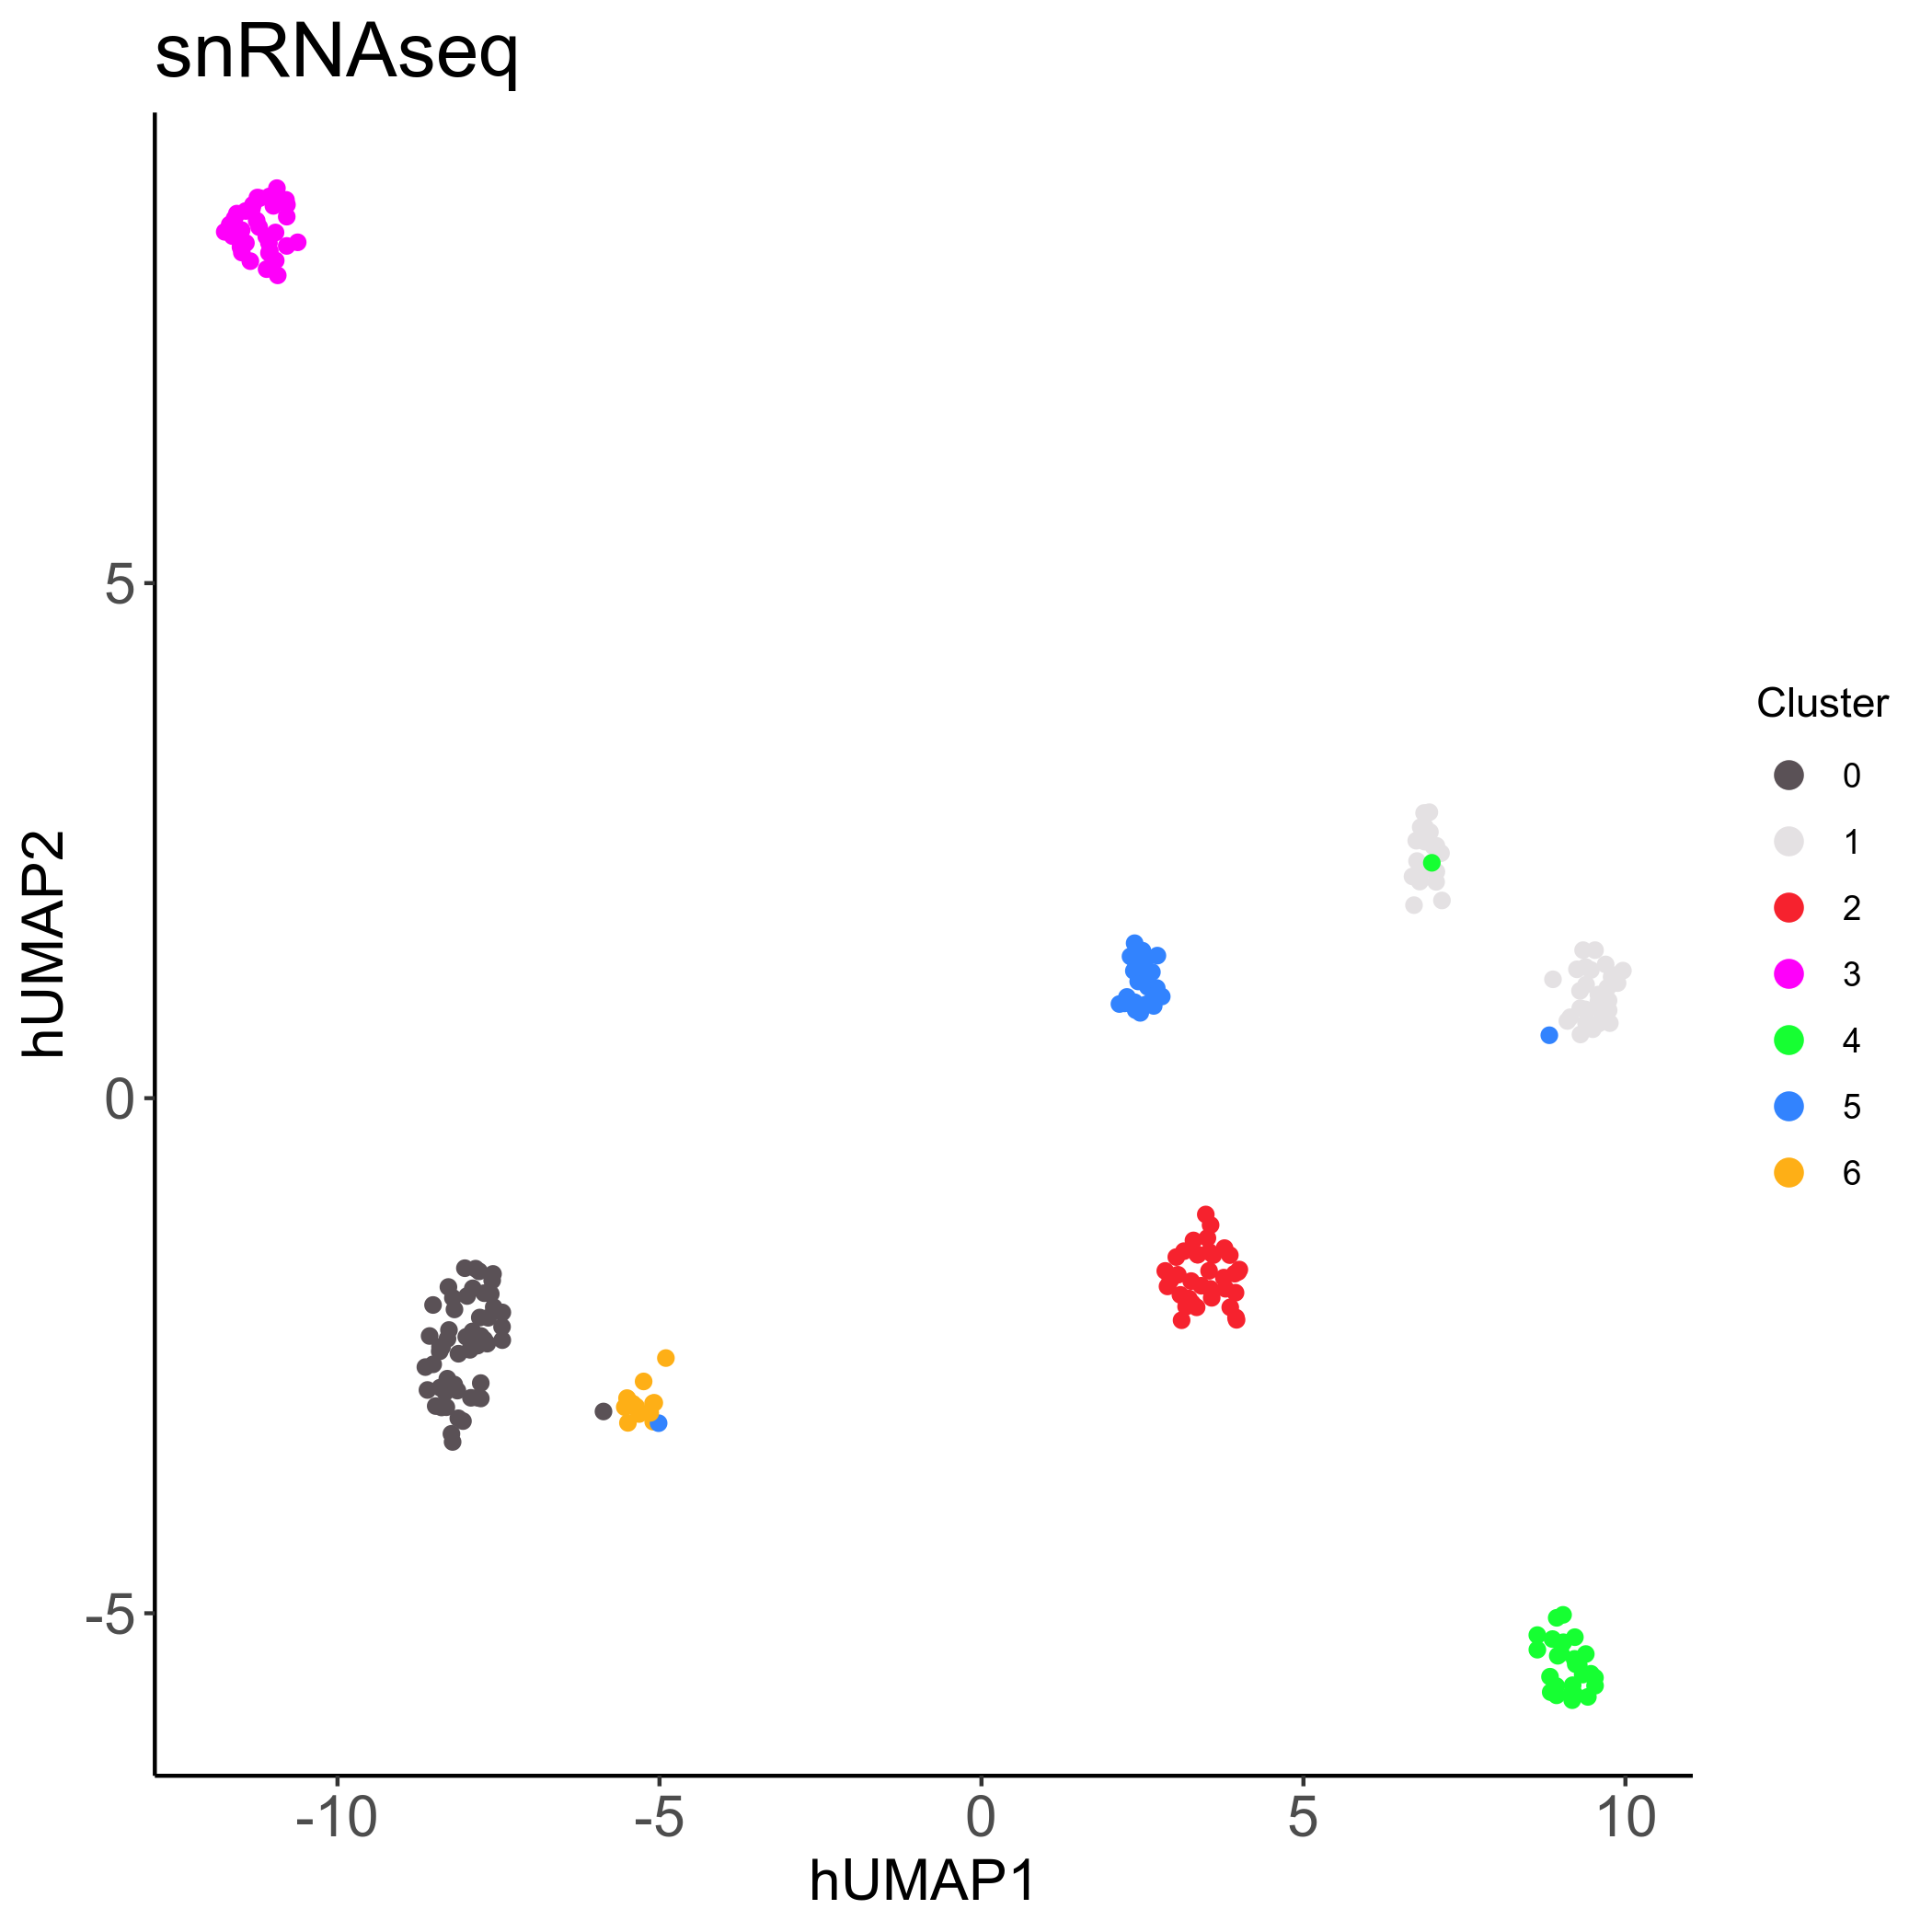

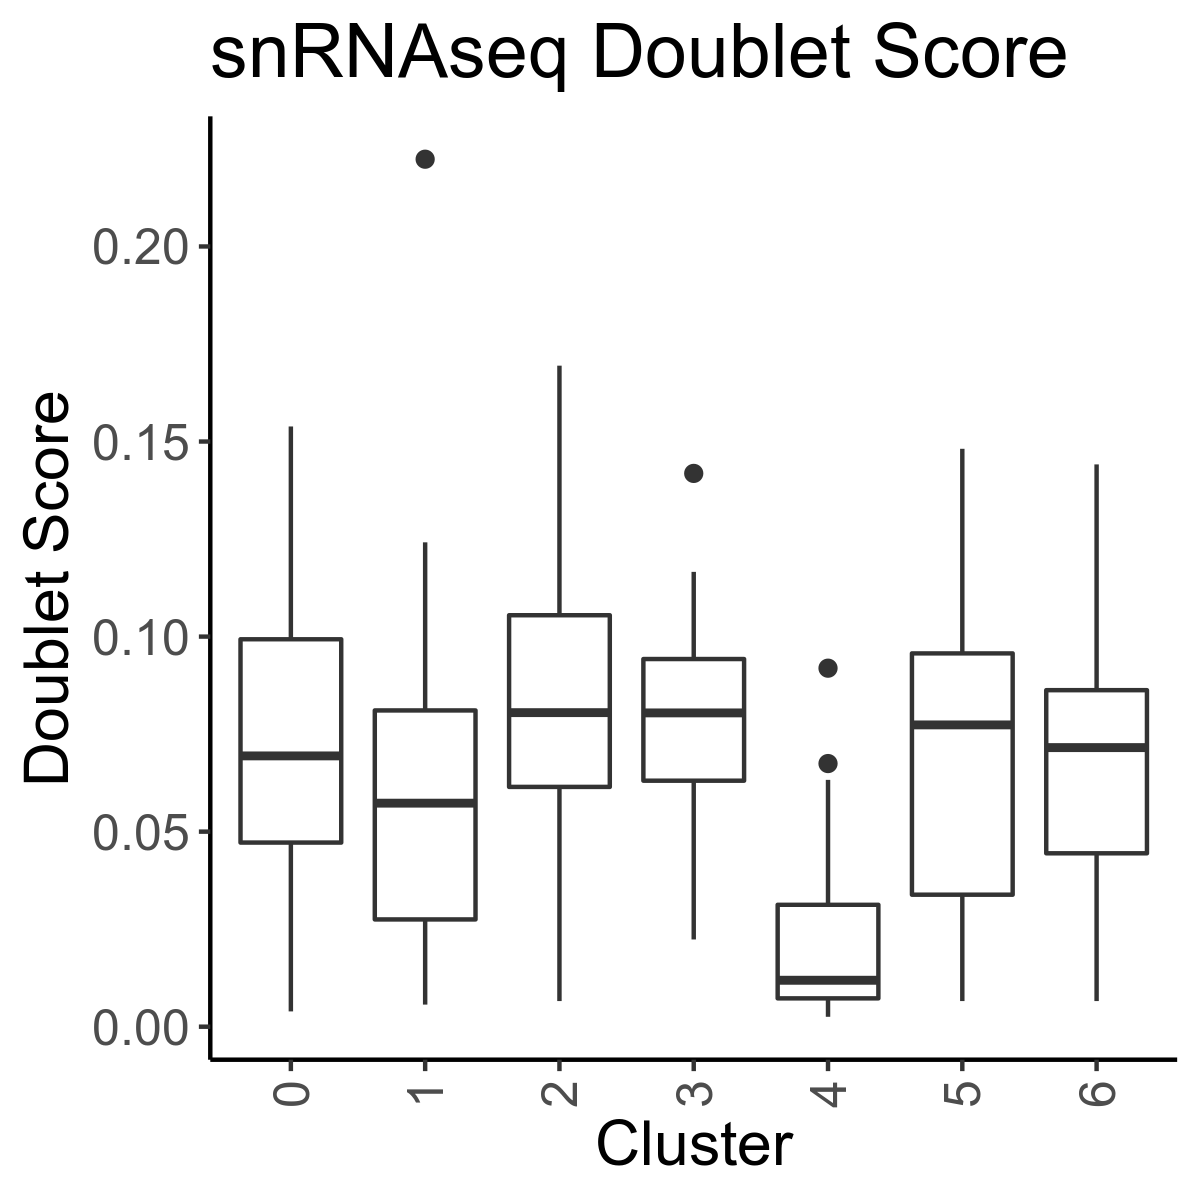

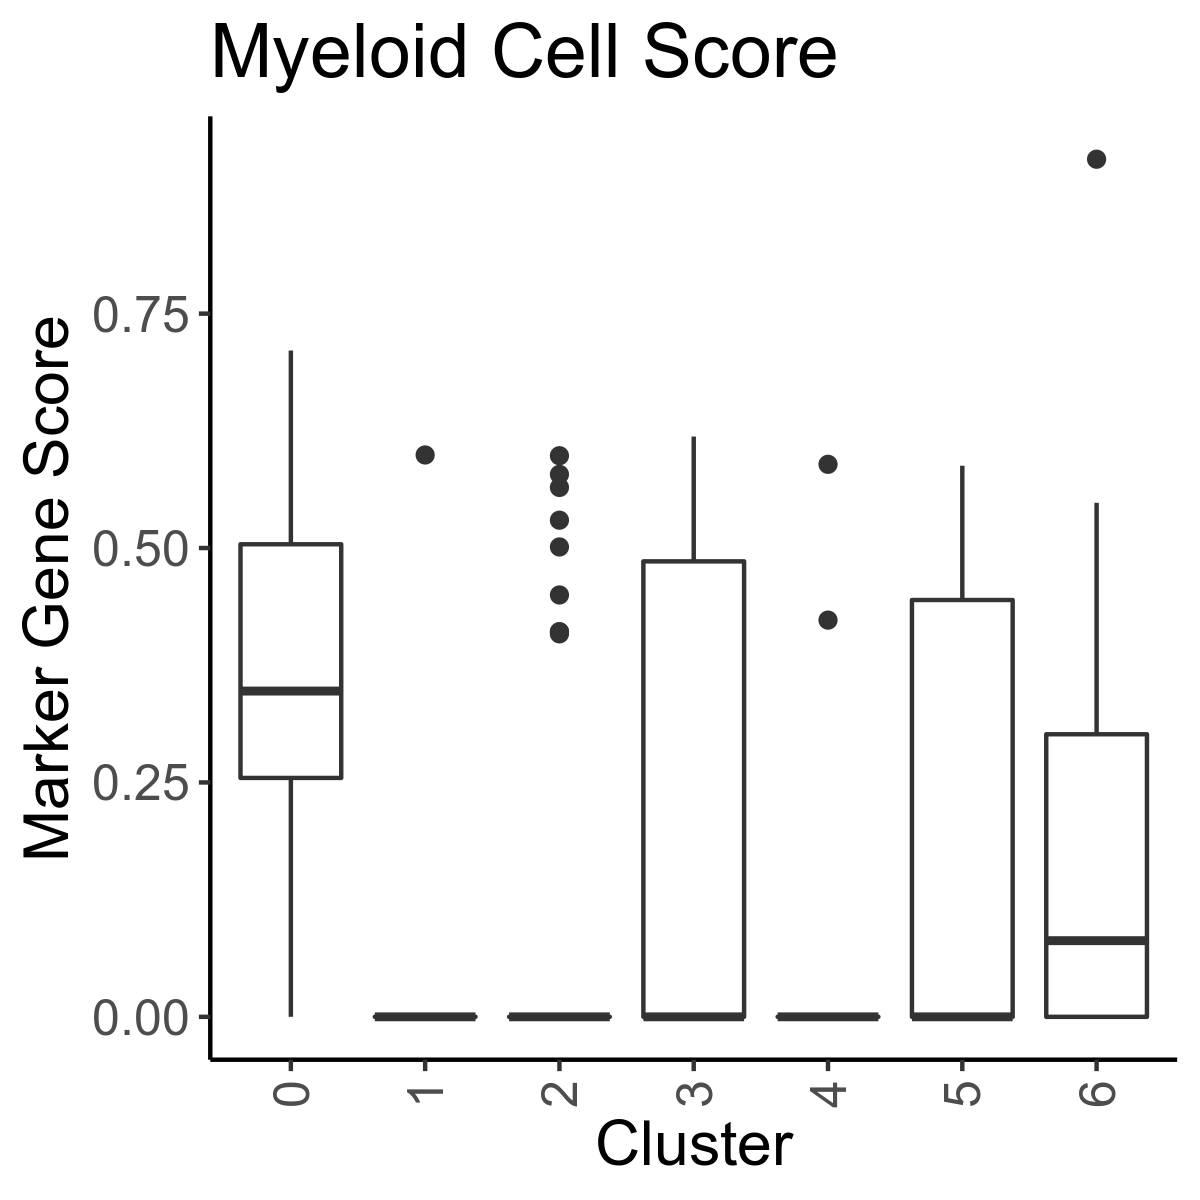

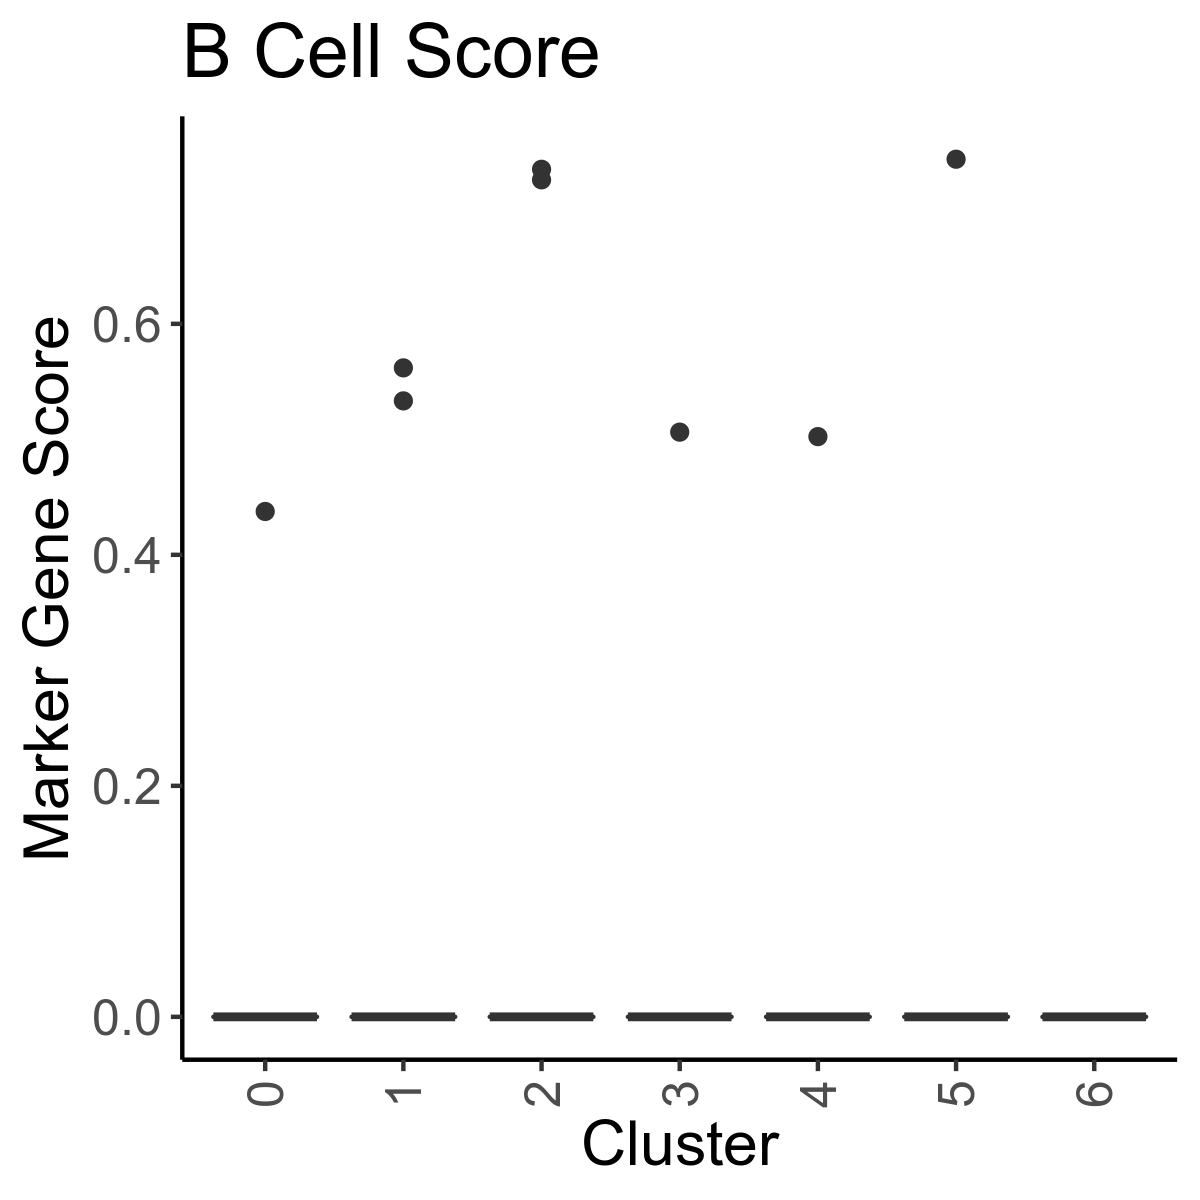

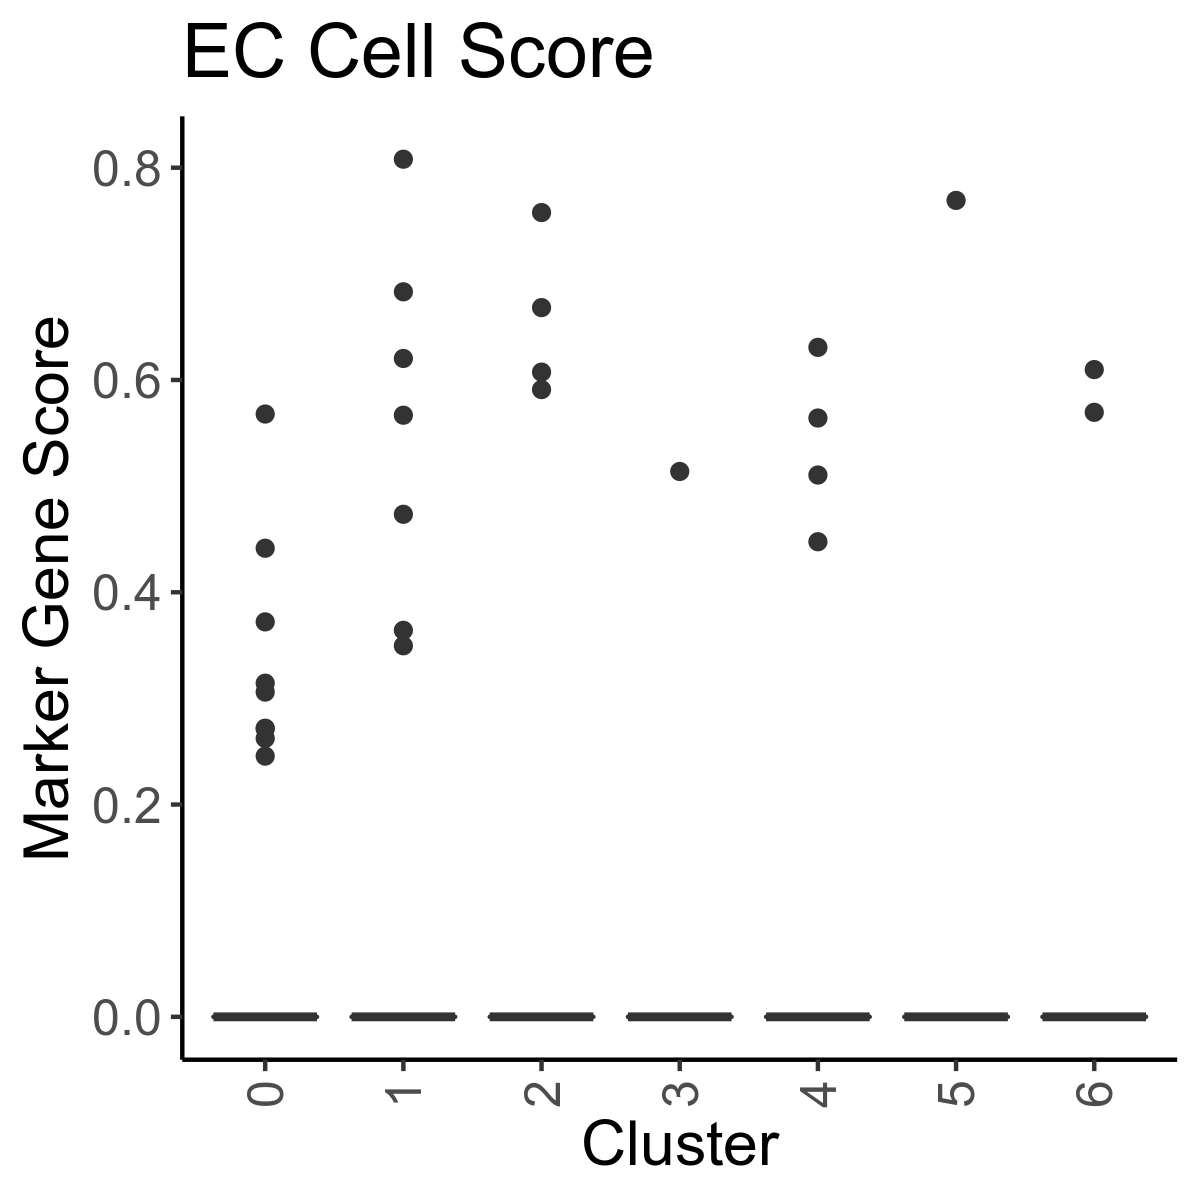

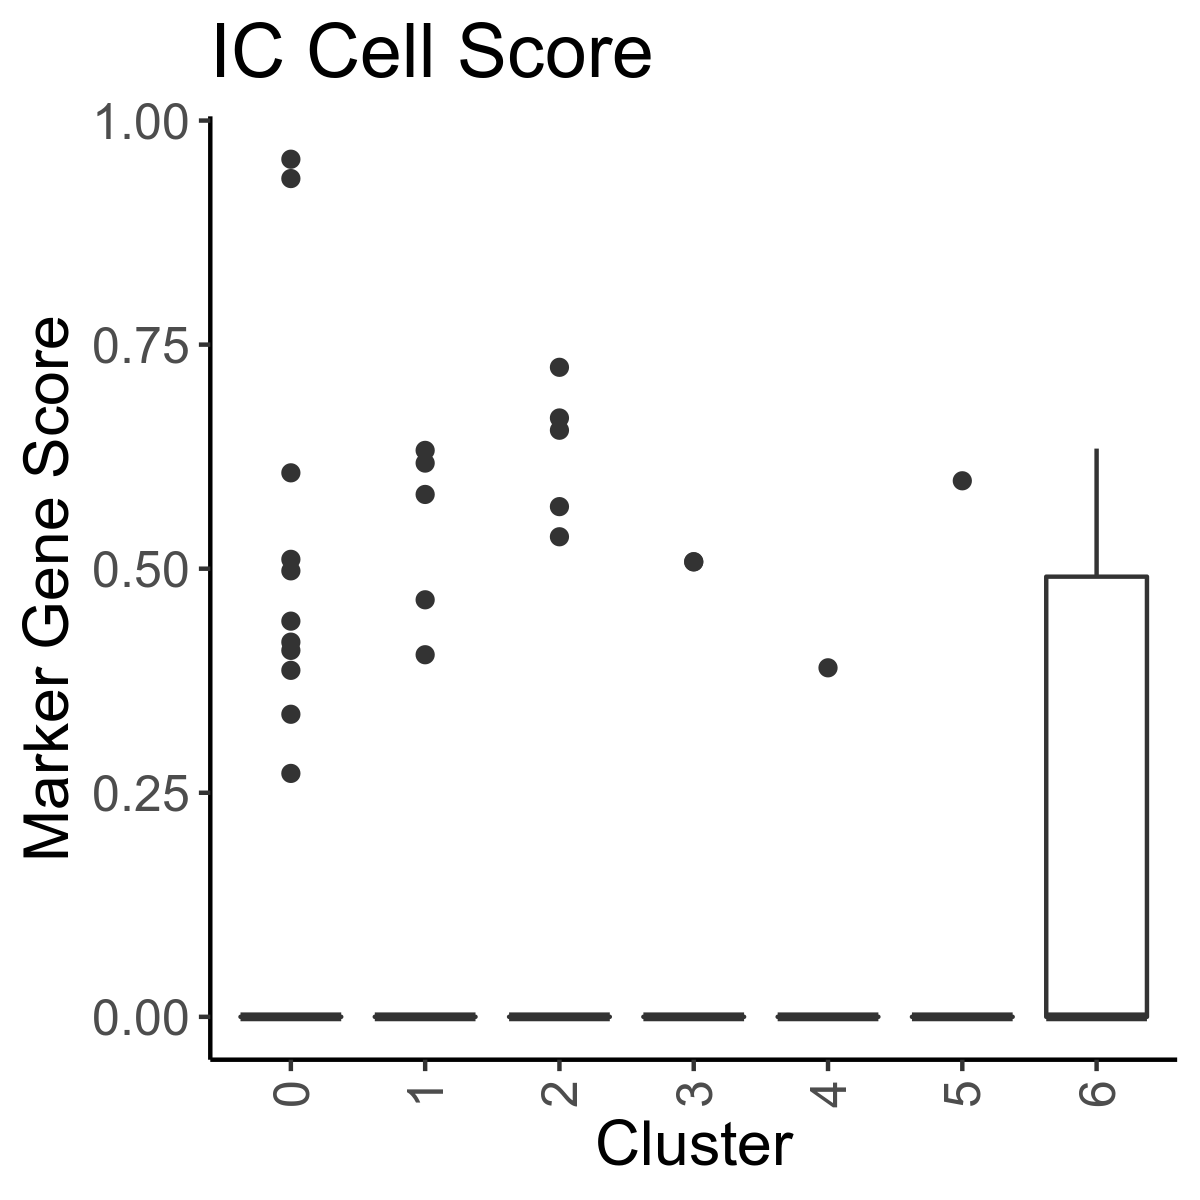

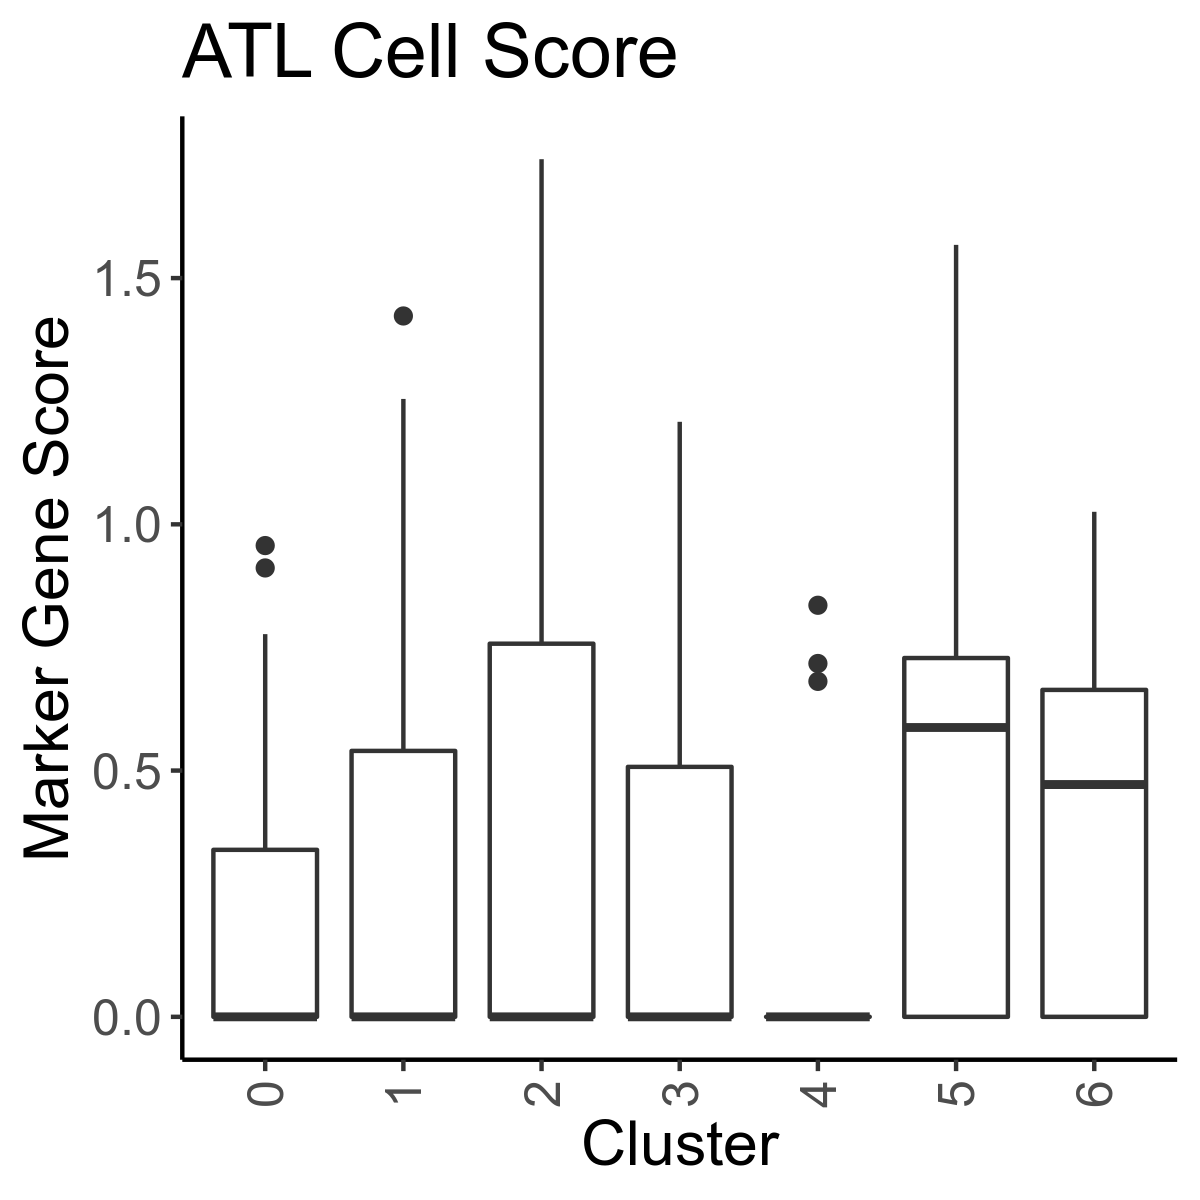

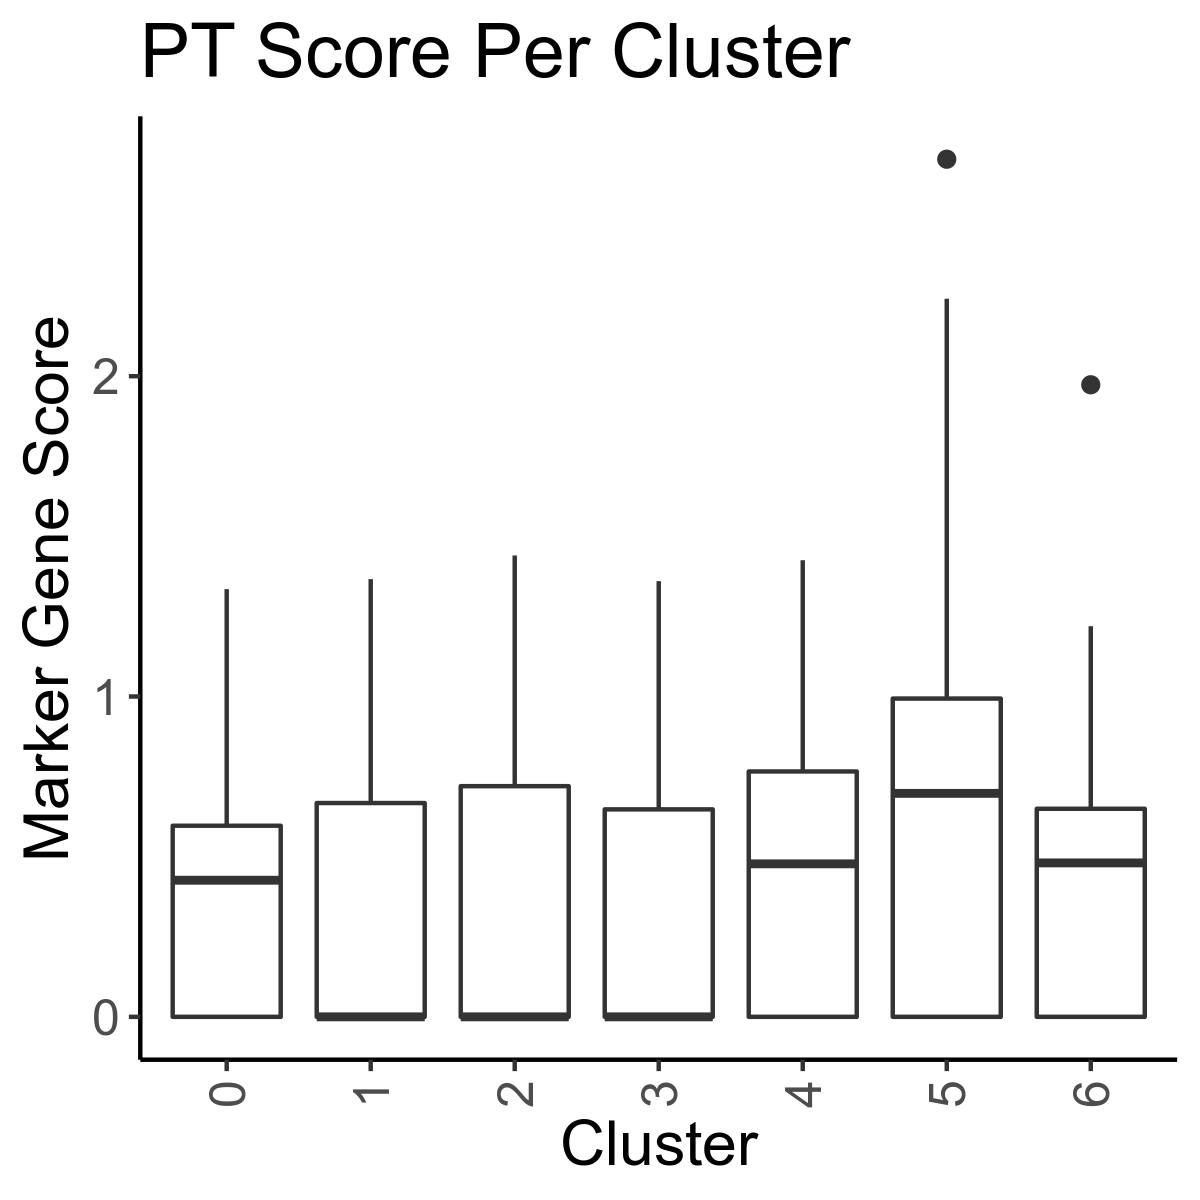

In [25]:
ggplot(nuc_meta %>% mutate(hUMAP1 = nk_humap_res_nuc[, 1], 
                           hUMAP2 = nk_humap_res_nuc[, 2]), 
                           aes(x = hUMAP1, y = hUMAP2, color = as.factor(qc_cluster))) + 
    geom_point() + 
    theme_classic() +
    scale_color_manual(values = c(as.vector(polychrome(29)), as.vector(alphabet2(7))), drop = FALSE) +
    theme(axis.text = element_text(size = 15), axis.title = element_text(size = 15), plot.title = element_text(size = 20)) +
    labs(title = 'snRNAseq') +
    guides(colour = guide_legend(override.aes = list(size=3), title="Cluster"))



fig.size(4, 4)
ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = doublet_score)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 6))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Doublet Score', title = 'snRNAseq Doublet Score ') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = Myeloid)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 6))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'Myeloid Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = B)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 6))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'B Cell Score') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))



ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = EC)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 6))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'EC Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = IC)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 6))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'IC Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = ATL)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 6))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'ATL Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(nuc_meta, aes(x = as.character(qc_cluster), y = PT)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 6))) + 
    theme(axis.text = element_text(size = 12), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'PT Score Per Cluster') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [26]:
## Filtering for expressed genes
threshold_genes <- sc_norm[rownames(sc_norm[rowMeans(sc_norm) >= .01, ]), ]

samples_25 <- sc_meta %>% group_by(sample) %>% tally() %>% filter(n > 25) %>% pull(sample)

threshold_samples <- threshold_genes[, sc_meta %>% filter(sample %in% samples_25) %>% pull(cell)]
 
## Variable gene selection — very inefficiently written, but essentially using VST to select most variable genes from samples with > 10 cells
var_genes_raw <- singlecellmethods::vargenes_vst(object = threshold_samples, groups = sc_meta %>% filter(sample %in% samples_25) %>% pull(sample), topn = 500)

In [27]:
## Scale Data
nk_scaled_sc <- sc_norm[var_genes_raw[! var_genes_raw %in% genes_exclude], ] %>% scaleData
## PCA
nk_pca_res_sc <- irlba::prcomp_irlba(t(nk_scaled_sc), 20)
## UMAP
nk_umap_res_sc <- uwot::umap(nk_pca_res_sc$x[, 1:20], n_neighbors = 30L, metric = "euclidean", min_dist = .1)

use_weights



[1] FALSE


use_weights

use_weights



[1] FALSE


use_weights

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony 6/20

Harmony 7/20

Harmony 8/20

Harmony 9/20

Harmony 10/20

Harmony 11/20

Harmony 12/20

Harmony 13/20

Harmony 14/20

Harmony 15/20

Harmony 16/20

Harmony 17/20

Harmony 18/20

Harmony 19/20

Harmony 20/20



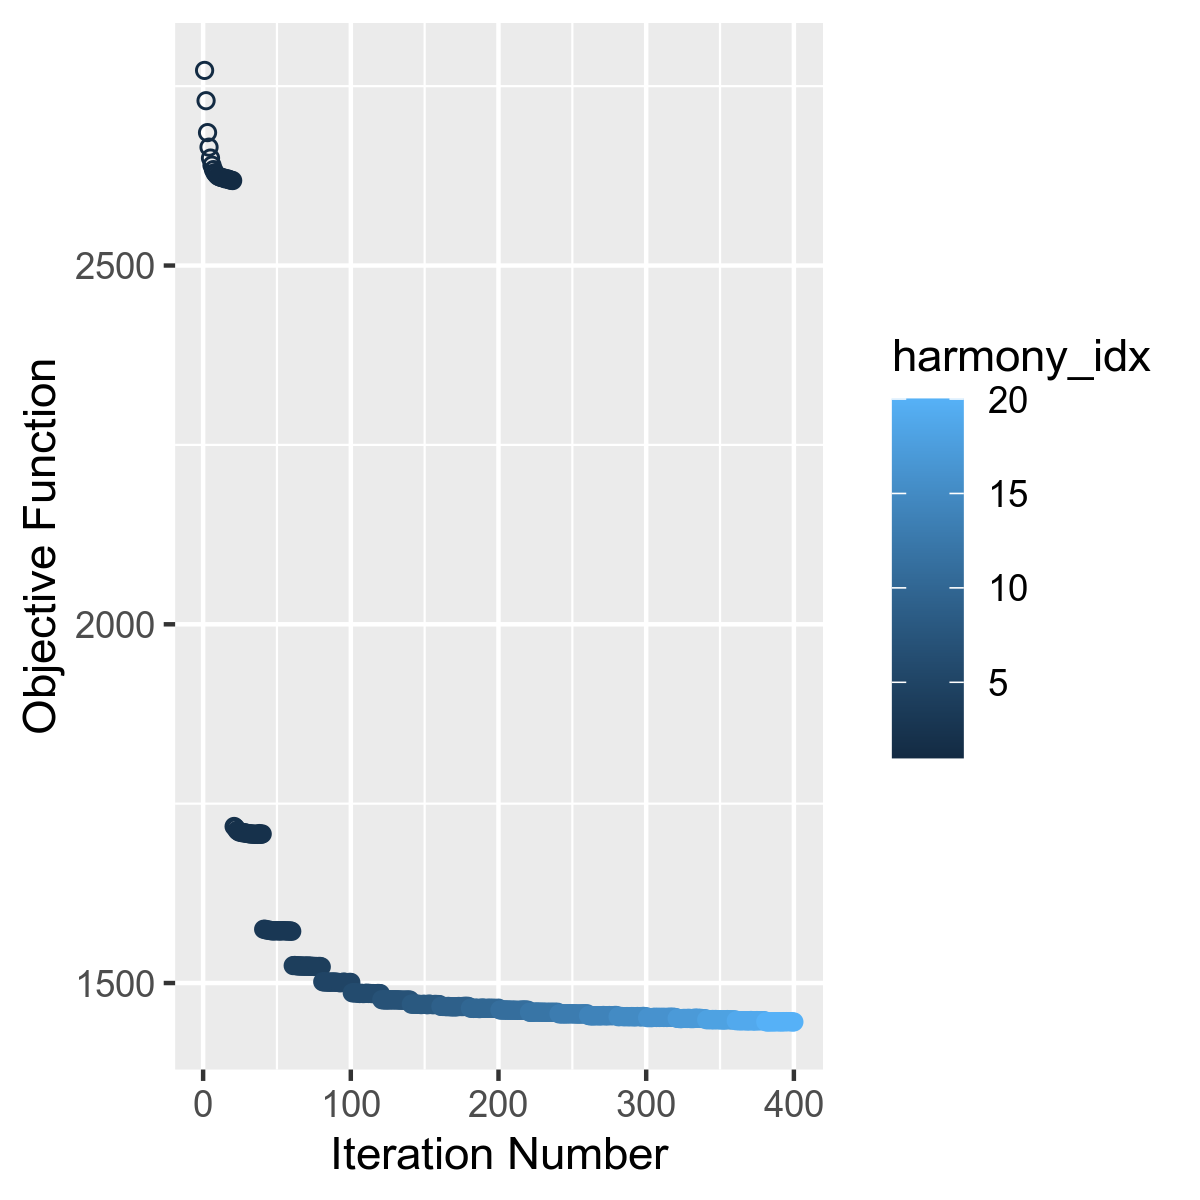

In [28]:
nk_harmony_sc <- HarmonyMatrix(nk_pca_res_sc$x[, 1:20], sc_meta, 
                                     vars_use = c("sample", "processing.batch", "Site"), 
                        # lambda = 1, 
                        # tau = 0, 
                        epsilon.cluster = -Inf,
                        epsilon.harmony = -Inf,
                        max.iter.cluster = 20,
                        max.iter.harmony = 20,
                        plot_convergence = TRUE,
                        npcs = 20, do_pca = FALSE)

In [30]:
nk_humap_res_sc <- uwot::umap(nk_harmony_sc[, 1:20], n_neighbors = 30L, metric = "euclidean", min_dist = .1)

In [31]:
snn_ref <- BuildSNNSeurat(nk_harmony_sc[,1:20], nn.eps = 0)

resolution_list <- c(2.0)
ids_ref_sc <- Reduce(cbind, mclapply(resolution_list, function(res_use) {
    Seurat:::RunModularityClustering(SNN = snn_ref, modularity = 1,
        resolution = res_use, algorithm = 1, n.start = 20,
        n.iter = 20, random.seed = 100, print.output = FALSE,
        temp.file.location = NULL, edge.file.name = NULL)
}, mc.preschedule = FALSE, mc.cores = min(20, length(resolution_list)))) 

In [32]:
sc_meta <- sc_meta %>% mutate(Myeloid = colMeans(sc_norm[rownames(sc_norm) %in% MYL, ]),
                                        T = colMeans(sc_norm[rownames(sc_norm) %in% T, ]), 
                                        B = colMeans(sc_norm[rownames(sc_norm) %in% B, ]),
                                        EC = colMeans(sc_norm[rownames(sc_norm) %in% EC, ]),
                                        IC = colMeans(sc_norm[rownames(sc_norm) %in% IC, ]),
                                        PC = colMeans(sc_norm[rownames(sc_norm) %in% PC_DCT_CNT, ]),
                                        ATL = colMeans(sc_norm[rownames(sc_norm) %in% ATL_TAL, ]),
                                        Fib = colMeans(sc_norm[rownames(sc_norm) %in% FIB, ]),
                                        Pod = colMeans(sc_norm[rownames(sc_norm) %in% POD, ]),
                                        PT = colMeans(sc_norm[rownames(sc_norm) %in% PT1, ]),
                                        MAST = colMeans(sc_norm[rownames(sc_norm) %in% MAST, ]),
                                        pDC = colMeans(sc_norm[rownames(sc_norm) %in% pDC, ]),
                                        qc_cluster = ids_ref_sc)

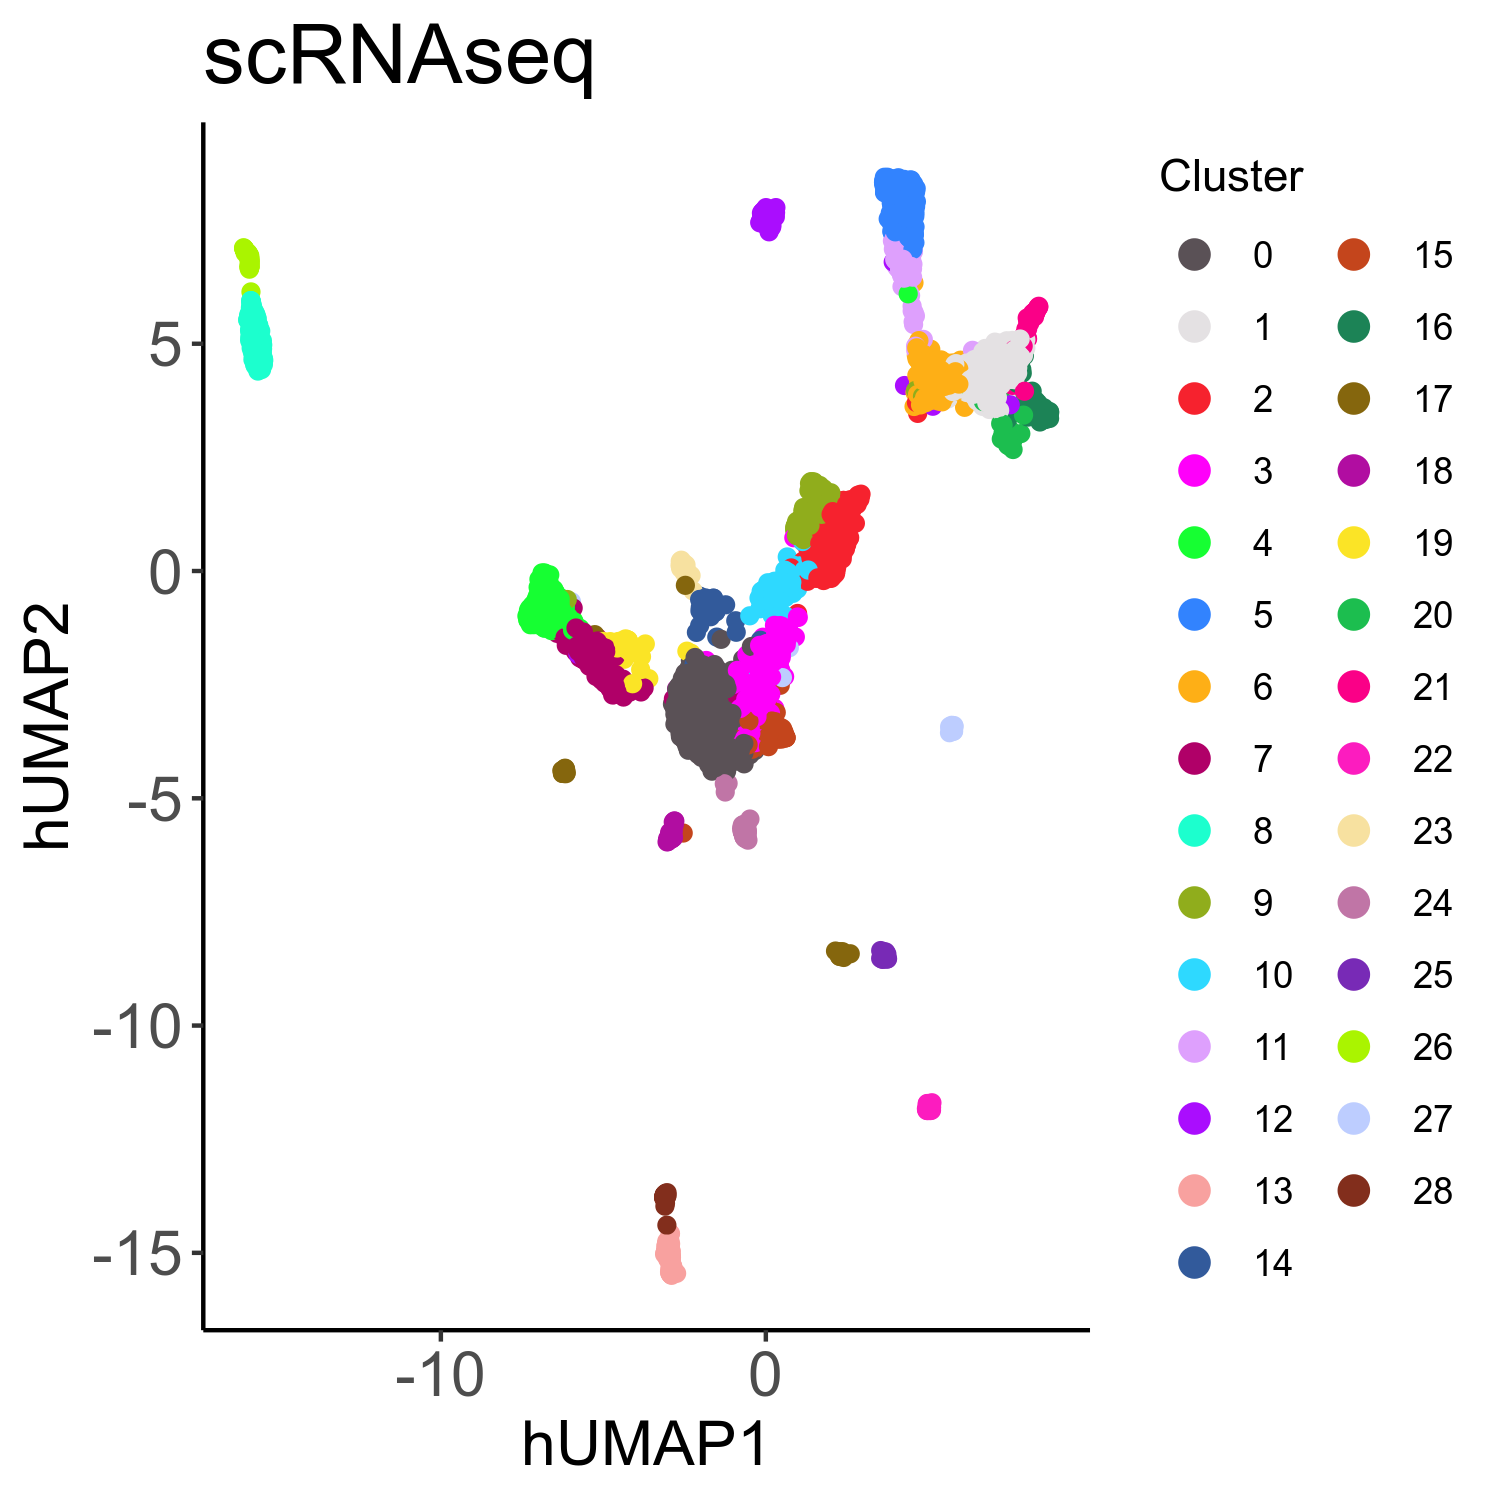

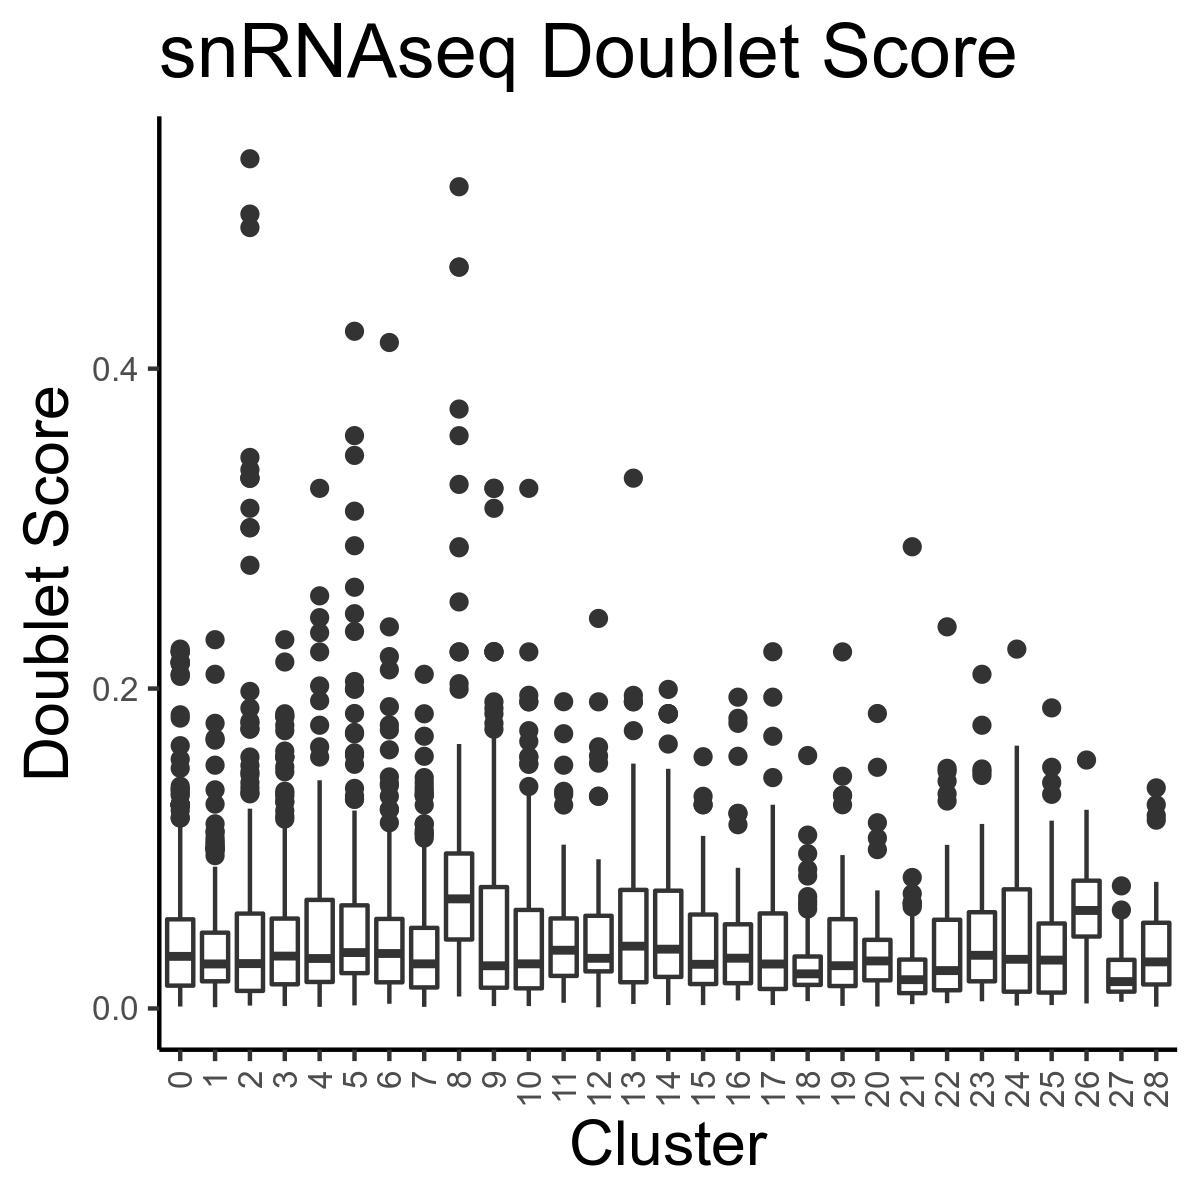

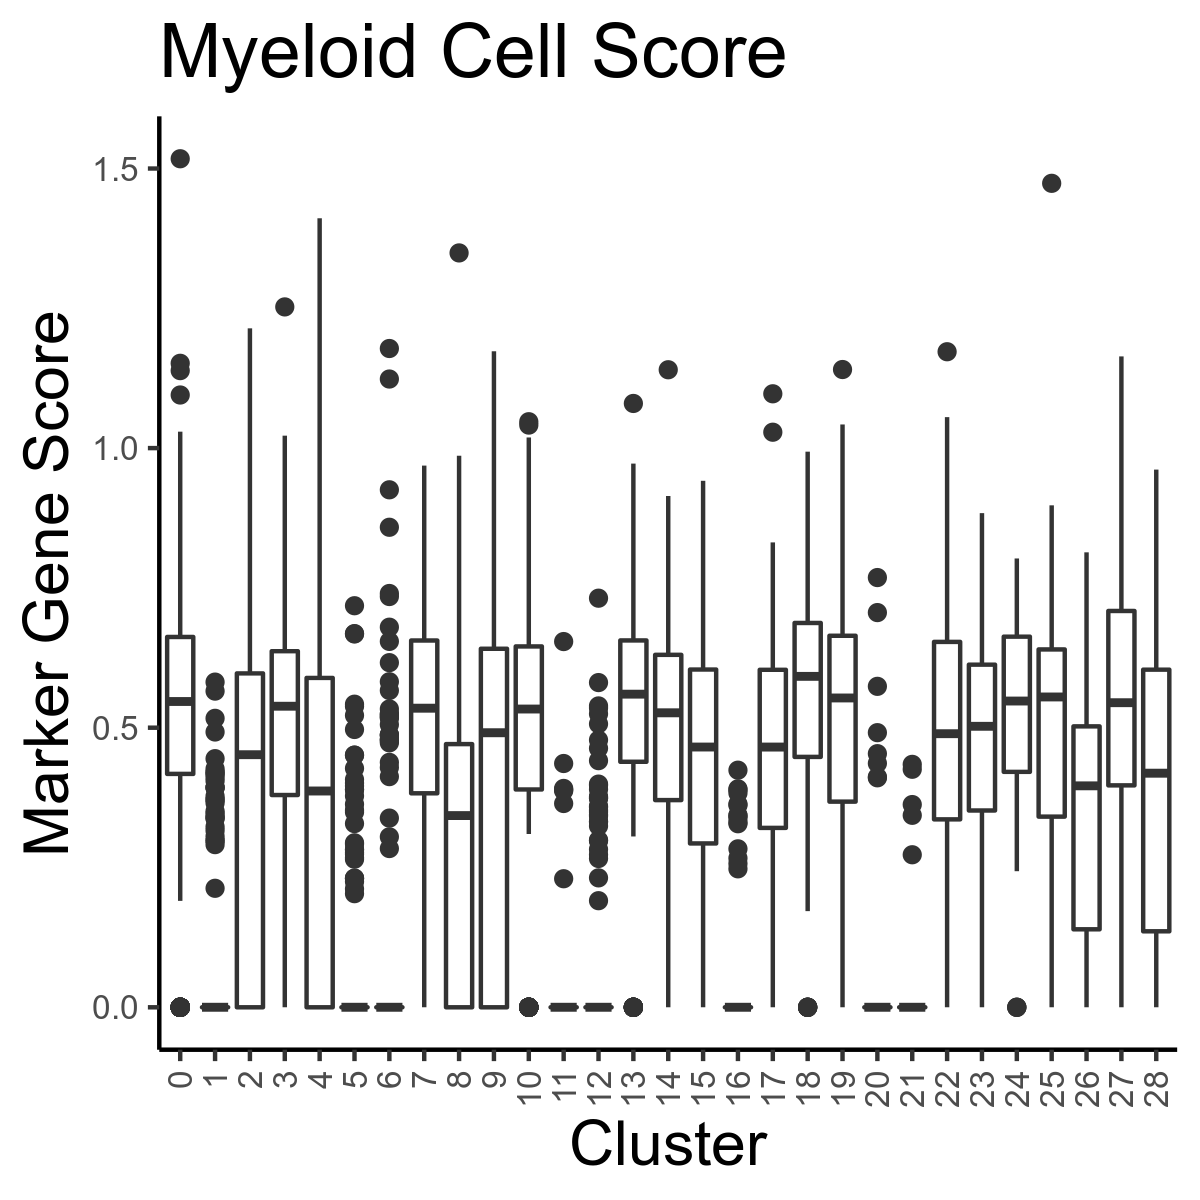

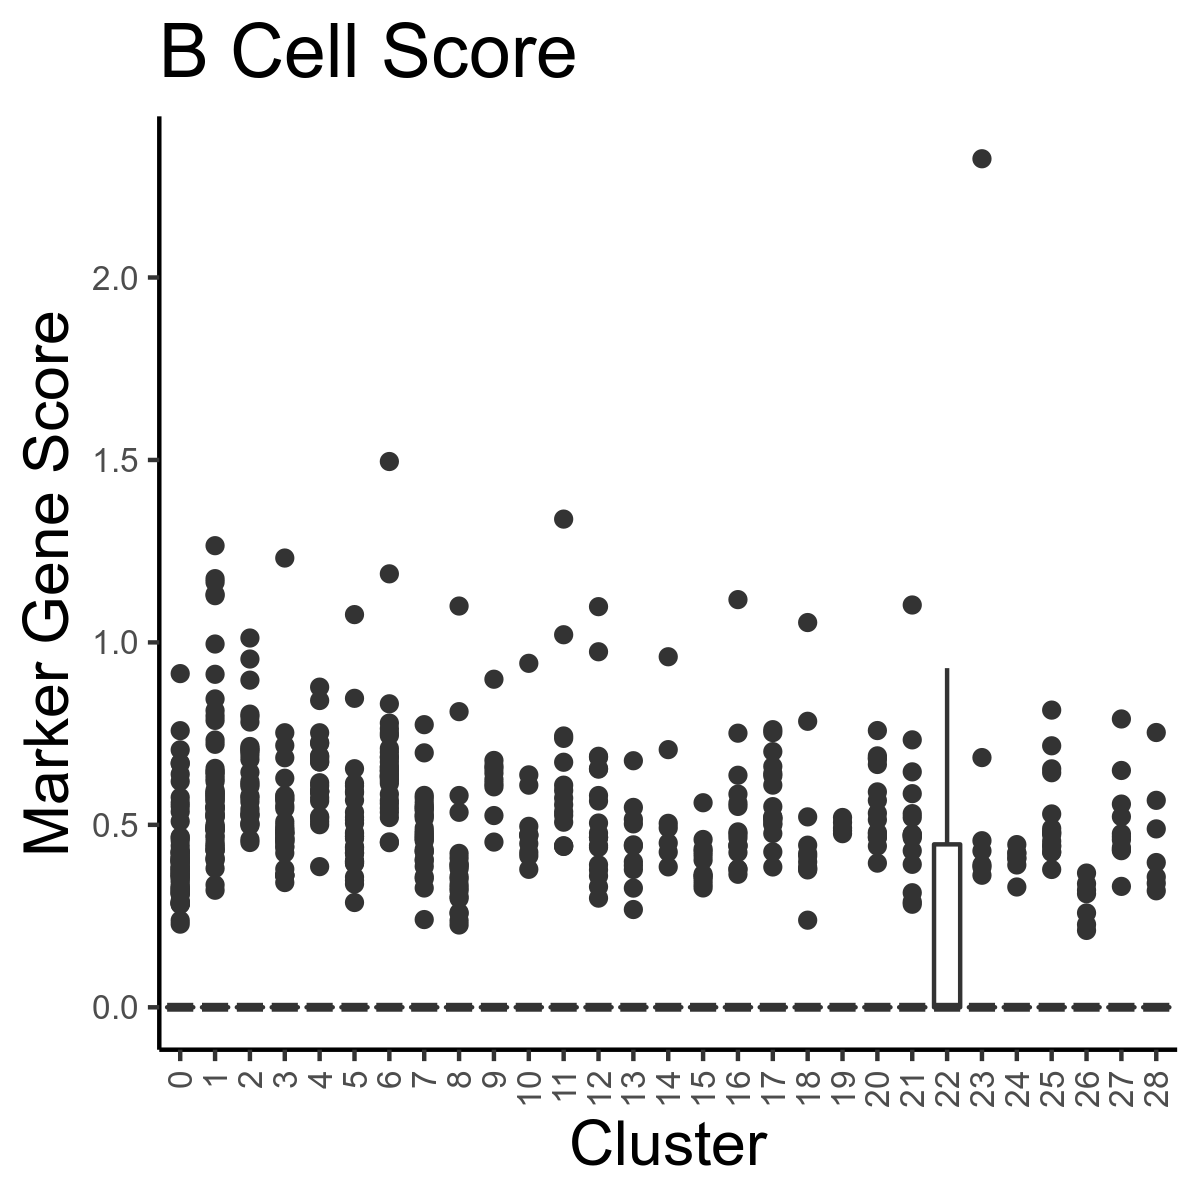

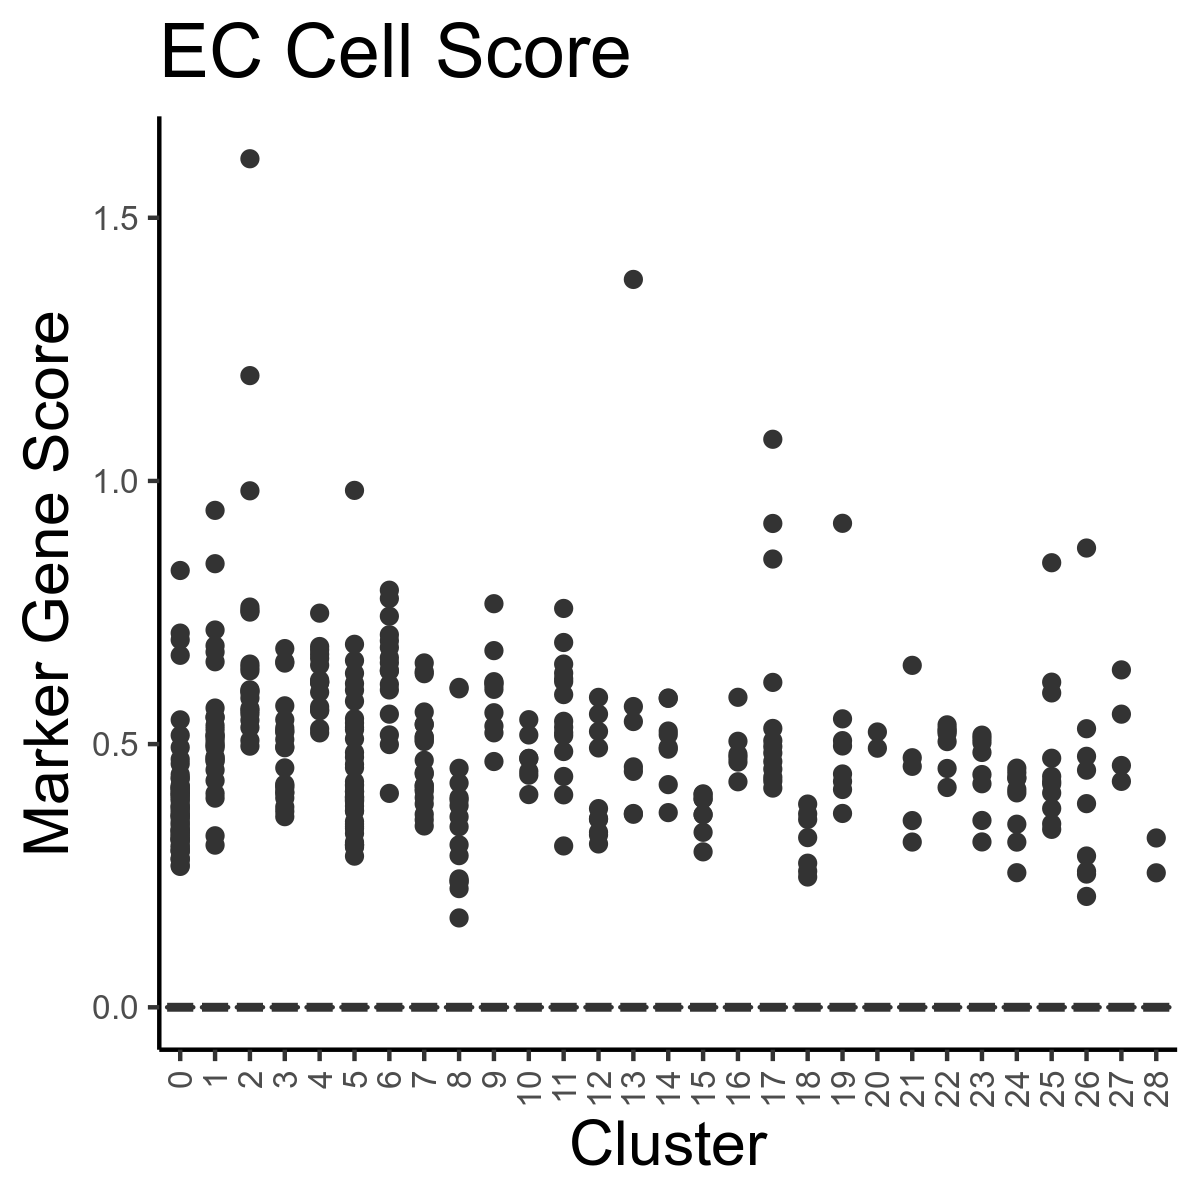

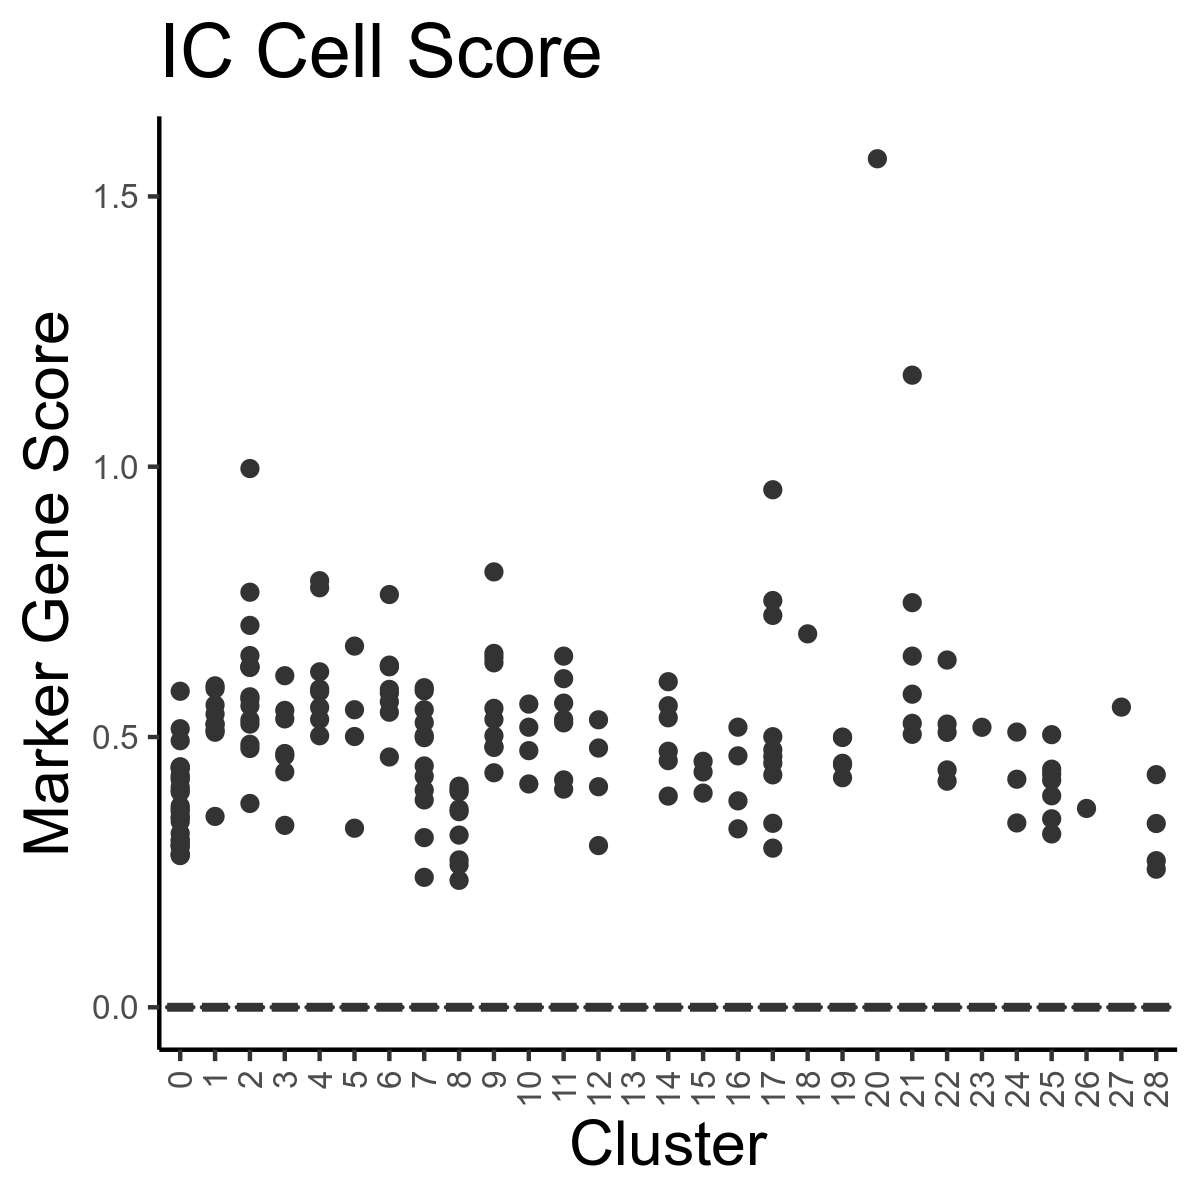

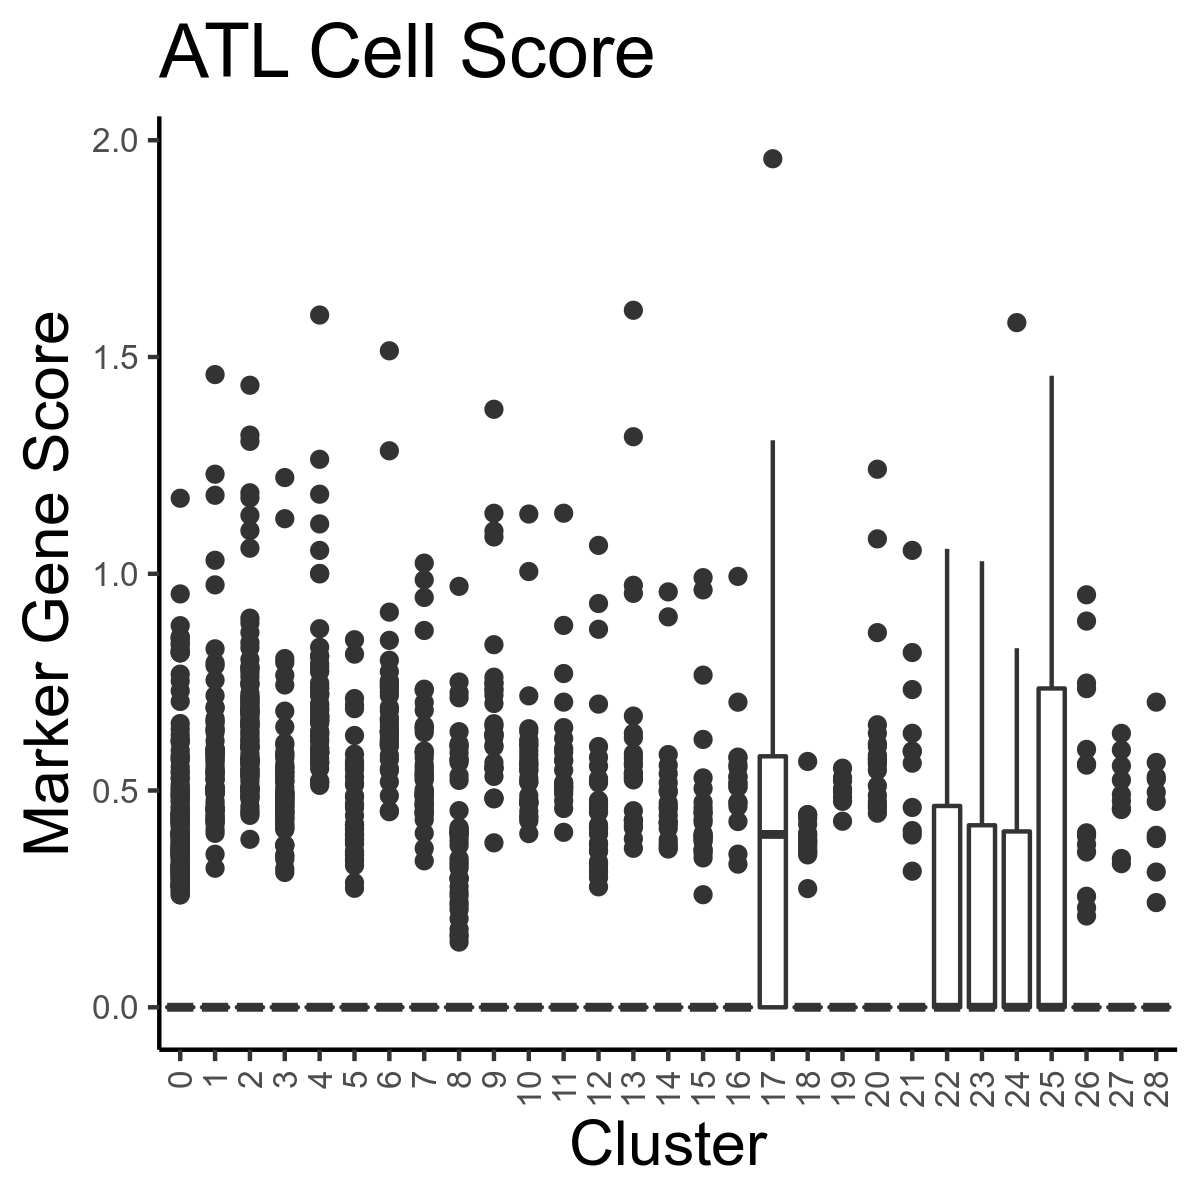

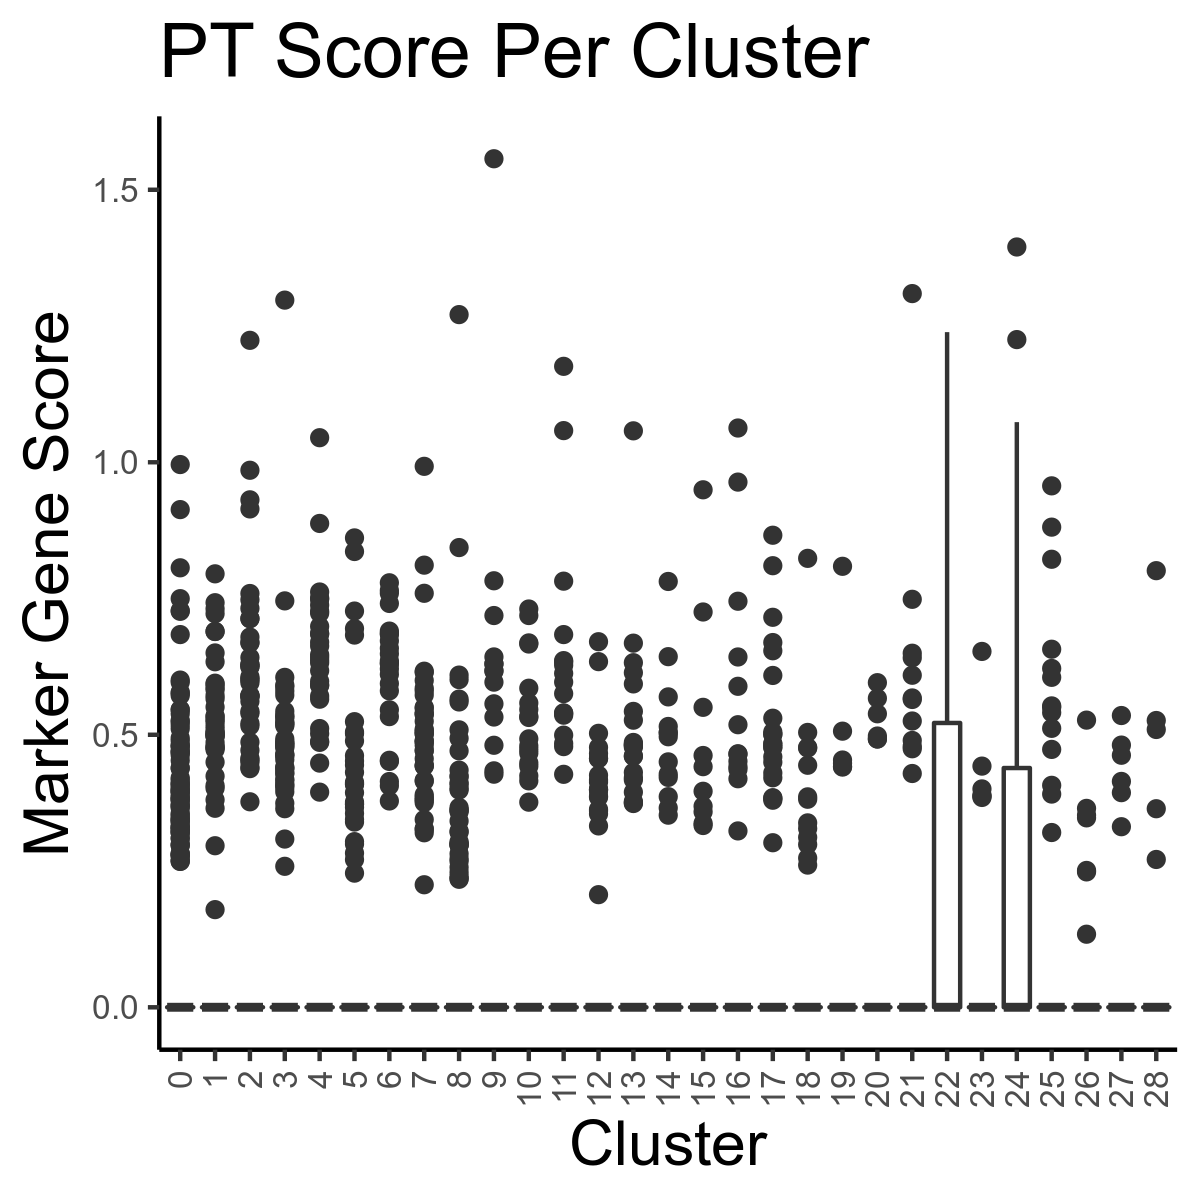

In [34]:
fig.size(5, 5)
ggplot(sc_meta %>% mutate(hUMAP1 = nk_humap_res_sc[, 1], 
                           hUMAP2 = nk_humap_res_sc[, 2]), 
                           aes(x = hUMAP1, y = hUMAP2, color = as.factor(qc_cluster))) + 
    geom_point() + 
    theme_classic() +
    scale_color_manual(values = c(as.vector(polychrome(29)), as.vector(alphabet(9))), drop = FALSE) +
    theme(axis.text = element_text(size = 15), axis.title = element_text(size = 15), plot.title = element_text(size = 20)) +
    labs(title = 'scRNAseq') +
    guides(colour = guide_legend(override.aes = list(size=3), title="Cluster"))



fig.size(4, 4)
ggplot(sc_meta, aes(x = as.character(qc_cluster), y = doublet_score)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 28))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Doublet Score', title = 'snRNAseq Doublet Score ') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


ggplot(sc_meta, aes(x = as.character(qc_cluster), y = Myeloid)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 28))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'Myeloid Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(sc_meta, aes(x = as.character(qc_cluster), y = B)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 28))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'B Cell Score') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))



ggplot(sc_meta, aes(x = as.character(qc_cluster), y = EC)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 28))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'EC Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(sc_meta, aes(x = as.character(qc_cluster), y = IC)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 28))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'IC Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(sc_meta, aes(x = as.character(qc_cluster), y = ATL)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 28))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'ATL Cell Score') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

ggplot(sc_meta, aes(x = as.character(qc_cluster), y = PT)) + 
    geom_boxplot() + 
    theme_classic() +
    scale_x_discrete(limits = factor(seq(0, 28))) + 
    theme(axis.text = element_text(size = 8), axis.title = element_text(size = 15), plot.title = element_text(size = 18)) +
    labs(x = 'Cluster', y = 'Marker Gene Score', title = 'PT Score Per Cluster') +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [35]:
qcd_meta <- rbind(sc_meta[, 1:17], nuc_meta[, 1:17])

In [36]:
qcd_norm <- nk_norm[, qcd_meta %>% pull(cell)]

In [37]:
saveRDS(qcd_meta, '/data/srlab/ssg34/SLE_kidney_v2/data/qcd/NK_refmapped_RA_qcd_meta_10252022.rds')
saveRDS(qcd_norm, '/data/srlab/ssg34/SLE_kidney_v2/data/qcd/NK_refmapped_RA_qcd_norm_10252022.rds')

## WEIGHTED PCA, HARMONY

In [9]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/NK_refmapped_RA_qcd_meta_10252022.rds')
qcd_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/NK_refmapped_RA_qcd_norm_10252022.rds')

In [10]:
# weighted PCA is in immunogenomics/singlecellmethods, function weighted_pca
weighted_pca <- function(X, weights, genes_use=NULL, npc=20, do_corr=TRUE, scale_thresh=10) {
    if (!identical(length(weights), ncol(X))) {
        stop('Columns in X must match length of weights')
    }
    
#     y <- factor(y)
#     weights <- as.numeric((1 / prop.table(table(y)))[y]) / nlevels(y)
    if (any(is.na(weights))) {
        idx_keep <- which(is.na(weights))
#         y <- y[idx_keep]
        weights <- weights[idx_keep]
        X <- X[, idx_keep]
    }
    if (is.null(genes_use)) {
        genes_use <- row.names(X)
    } else if (length(genes_use) < nrow(X)) {
        if (any(!genes_use %in% row.names(X))) {
            stop('genes_use not in rownames of X')
        }
        X <- X[genes_use, ]
    }
    
    ## weighted z-scores
#     mu <- X %>% apply(1, function(x) {SDMTools:::wt.mean(x, weights)})
#     sig <- X %>% apply(1, function(x) {SDMTools:::wt.sd(x, weights)})
    mu <- singlecellmethods::rowMeans(X, weights = weights)
    sig <- singlecellmethods::rowSDs(X, weights = weights)
    
    # Added 12/9/19: save weighted scaling means and std devs
    vargenes_means_sds <- tibble(
        symbol = genes_use,
        mean = mu
    )
    vargenes_means_sds$stddev <- sig
    # finish added 12/9/19
    
    X <- scaleDataWithStats(X, mu, sig) 
    X <- X[which(is.na(rowSums(X)) == 0), ]
    if (do_corr) {
        X <- X %>% scale() %>% pmin(scale_thresh) %>% pmax(-scale_thresh)
    }
    
    ## weighted SVD
#     pres <- rsvd::rsvd(X %*% Matrix::Diagonal(x = sqrt(weights)), k = npc)
    pres <- RSpectra::svds(X %*% Matrix::Diagonal(x = sqrt(weights)), npc)
    V <- (Matrix::Diagonal(x = 1 / sqrt(weights)) %*% pres$v) %*% diag(pres$d)
    V <- as.matrix(V)
    colnames(V) <- paste0('PC', 1:npc)
    row.names(V) <- colnames(X)
    colnames(pres$u) <- paste0('PC', 1:npc)
    row.names(pres$u) <- row.names(X)
    return(list(loadings = pres$u, embeddings = V, vargenes = vargenes_means_sds))
}

# Cosine normalize values
cosine_normalize <- function(X, MARGIN = 1, do_safe = TRUE) {
    if (do_safe) {
        X <- sweep(X, MARGIN, apply(X, MARGIN, max), "/")
    }
    sweep(X, MARGIN, apply(X, MARGIN, function(x) sqrt(sum(x^2))), "/")
}
                           
                                                    
do_pca <- function(X, weights, genes_use=NULL, npc=10, do_corr=TRUE) {
    if (is.null(genes_use)) {
        genes_use <- row.names(X)
    }
    mu <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.mean(x, weights)})
    sig <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.sd(x, weights)})
    
    X <- X[genes_use, ] %>% scaleDataWithStats(mu, sig) 
    X <- X[which(is.na(rowSums(X)) == 0), ]
    if (do_corr) {
        X <- scale(X)
    }
    pres <- rsvd::rsvd(X, k = npc)
    V <- pres$v %*% diag(pres$d)
    V <- data.table(V)
    colnames(V) <- paste0('PC', 1:npc)
    return(V)    
}
                           
get_stats <- function(X, weights, genes_use=NULL) {
    if (is.null(genes_use)) {
        genes_use <- row.names(X)
    }
    mu <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.mean(x, weights)})
    sig <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.sd(x, weights)})
    return(list(mu = mu, sig = sig))
}
                           
                           
plot_shuffled_features <- function(ab, umap, exprs, pct) {
    library(viridis)
    max.cutoff = quantile(exprs[ab,], pct)
    min.cutoff = quantile(exprs[ab,], 1-pct)
    
    tmp <- sapply(X = exprs[ab,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    umap_res_plot <- cbind(umap, tmp)
    return(ggplot(data = as.data.frame(umap_res_plot)[sample(nrow(umap_res_plot)),] , aes(x = V1, y = V2)) +
      geom_point(mapping = aes(color = tmp), size = 0.75) +
      scale_color_viridis(option = "inferno", end = pct) +
      theme_classic() +
      theme(plot.title = element_text(size = 15), legend.position = "none") +
      labs(title = ab, x = 'hUMAP1', y = 'hUMAP2', color = "Normalized Expression"))
}
                           fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 300)
}
                           
                           
vargenes_vst <- function(object, groups, topn, loess.span = 0.3) {
    clip.max <- sqrt(ncol(object))

    N <- ncol(object)
    if (missing(groups)) {
        groups <- rep('A', N)
    }
    
    res <- split(seq_len(N), groups) %>% lapply(function(idx) {
        object_group <- object[, idx]
        ## row means
        hvf.info <- data.frame(
          symbol = rownames(object_group), 
          mean = Matrix::rowMeans(object_group)
        )

        ## row vars
        hvf.info$variance <- rowVars(object_group, hvf.info$mean)

        ## initialize
        hvf.info$variance.expected <- 0
        hvf.info$variance.standardized <- 0

        not.const <- hvf.info$variance > 0

        ## loess curve fit 
        suppressWarnings({
            fit <- loess(formula = log10(variance) ~ log10(mean), 
                data = hvf.info[not.const, ], span = loess.span)            
        })

        ## extract fitted variance 
        hvf.info$variance.expected[not.const] <- 10^fit$fitted

        ## get row standard deviations after clipping
        hvf.info$variance.standardized <- rowVarsStd(
            object_group, 
            hvf.info$mean, 
            sqrt(hvf.info$variance.expected), 
            clip.max
        )

        hvf.info <- hvf.info %>% 
#             tibble::rownames_to_column('symbol') %>% 
            arrange(-variance.standardized) %>% 
            tibble::rowid_to_column('rank') %>% 
            transform(group = unique(groups[idx]))

        return(hvf.info)        
    })
    
    
    if (missing(topn)) {
        ## MODE 1: return table 
        res <- Reduce(rbind, res) %>% 
            dplyr::select(group, symbol, rank, everything())

        if (length(unique(res$group)) == 1) {
            res$group <- NULL
        }
    } else {
        ## MODE 2: return genes
        res <- lapply(res, function(x) head(x, topn)$symbol)
    }
    return(res)
}

In [11]:
## Filtering for expressed genes
threshold_genes <- qcd_norm[rownames(qcd_norm[rowMeans(qcd_norm) >= .01, ]), ]

samples_25 <- qcd_meta %>% group_by(sample) %>% tally() %>% filter(n > 10) %>% pull(sample)

threshold_samples <- threshold_genes[, qcd_meta %>% filter(sample %in% samples_25) %>% pull(cell)]

## Variable gene selection — very inefficiently written, but essentially using VST to select most variable genes from samples with > 100 cells
var_genes_raw <- vargenes_vst(object = threshold_samples, groups = qcd_meta %>% filter(sample %in% samples_25) %>% pull(sample), topn = 500)

In [12]:
#Separate variable genes by Dataset
var_genes_raw_nuc <- vector()
var_genes_raw_sc <- vector()

for (i in 1:length(var_genes_raw)) {
    if (grepl('nuc', names(var_genes_raw)[i])) {
        var_genes_raw_nuc <- c(var_genes_raw_nuc, var_genes_raw[[i]])
    }
    else {
        var_genes_raw_sc <- c(var_genes_raw_sc, var_genes_raw[[i]])   
    }

}

var_genes_raw_nuc <- var_genes_raw_nuc %>% unique()
var_genes_raw_sc <- var_genes_raw_sc %>% unique() 
#Find intersection
var_genes <- intersect(var_genes_raw_nuc, var_genes_raw_sc)

In [13]:
## Scale Data
nk_scaled <- qcd_norm[var_genes[!var_genes %in% genes_exclude], ] %>% scaleData()

In [14]:
table(qcd_meta$dataset)
y <- factor(qcd_meta$dataset)
weights <- as.numeric((1 / prop.table(table(y)))[y]) / nlevels(y)
length(weights)
table(weights)


scRNAseq snRNAseq 
    4946      244 

[1] 5190

weights
0.524666397088556  10.6352459016393 
             4946               244 

In [15]:
nk_scaled <- as(nk_scaled, 'dgCMatrix')

In [16]:
dim(nk_scaled)

[1] 2739 5190

In [17]:
weighted_pca_res <- weighted_pca(nk_scaled, weights, rownames(nk_scaled), 20, TRUE, 10)$embeddings

In [ ]:
harmony_weighted2 <- HarmonyMatrix(weighted_pca_res, qcd_meta, 
                            c('sample', 'processing.batch', 
                              'Site', 'dataset'), 
                            theta = c(0.75, 0.25, 0.25, 0.75),
                            sigma = c(0.25),
                            do_pca = FALSE, 
                            epsilon.harmony = -Inf, 
                            epsilon.cluster = -Inf,
                            weights = weights, 
                            max.iter.cluster = 20,
                            max.iter.harmony = 20, 
                            plot_convergence = TRUE, 
                            verbose = TRUE)

use_weights



[1] TRUE


use_weights

use_weights



[1] TRUE


use_weights

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony 6/20



In [63]:
harmony_umap2 <- uwot::umap(harmony_weighted2, n_neighbors = 30L, min_dist = 0.1, metric = 'euclidean')
weighted_umap <- uwot::umap(weighted_pca_res, n_neighbors = 30L, min_dist = 0.1, metric = 'euclidean')

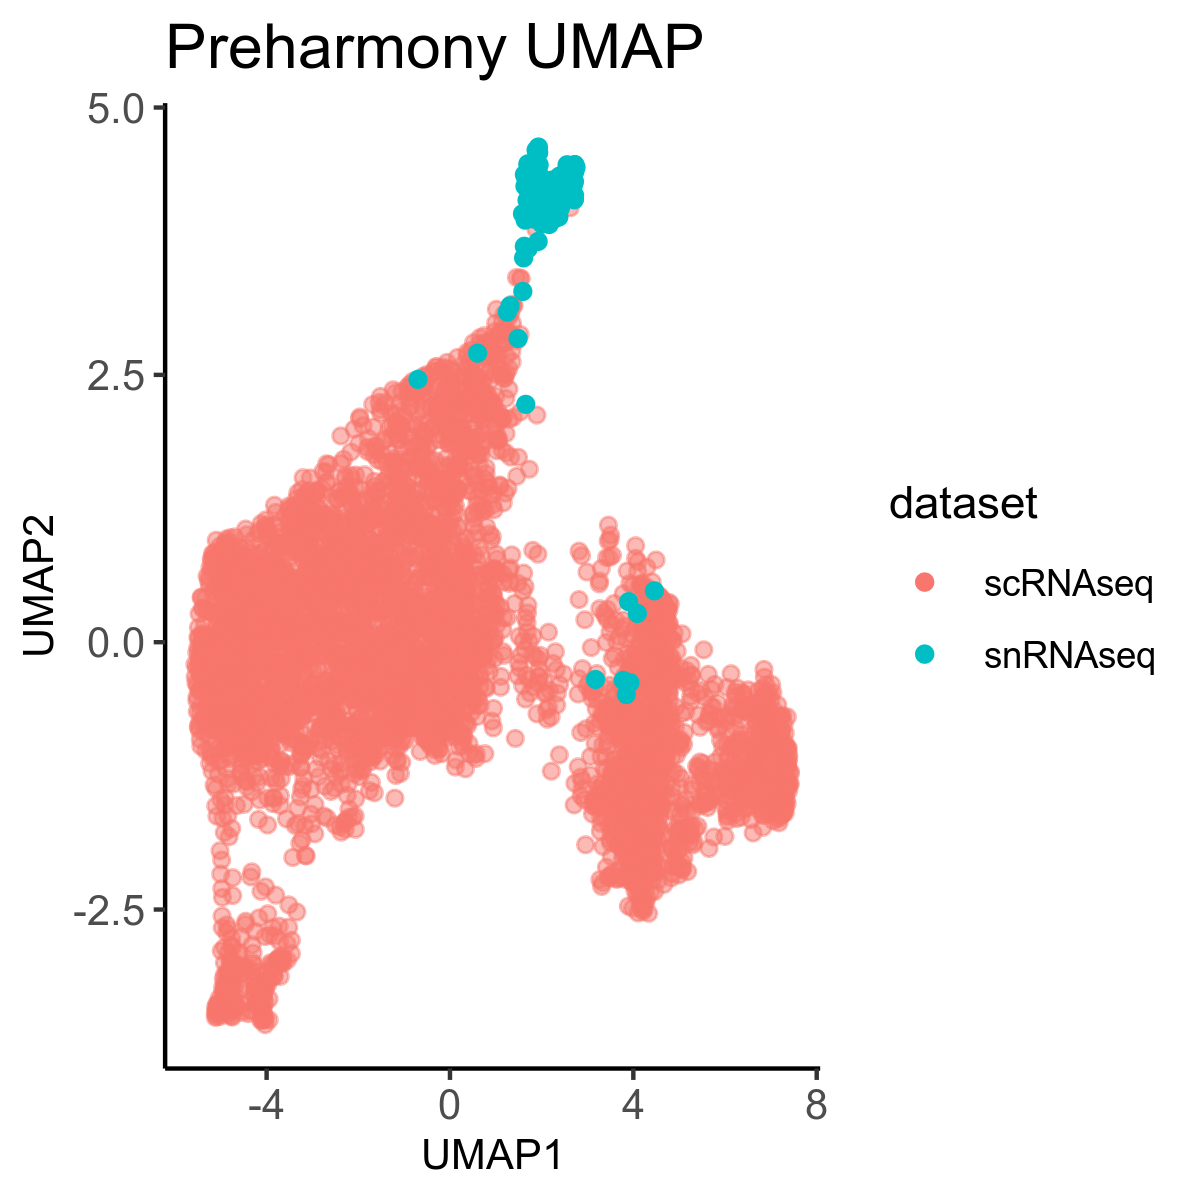

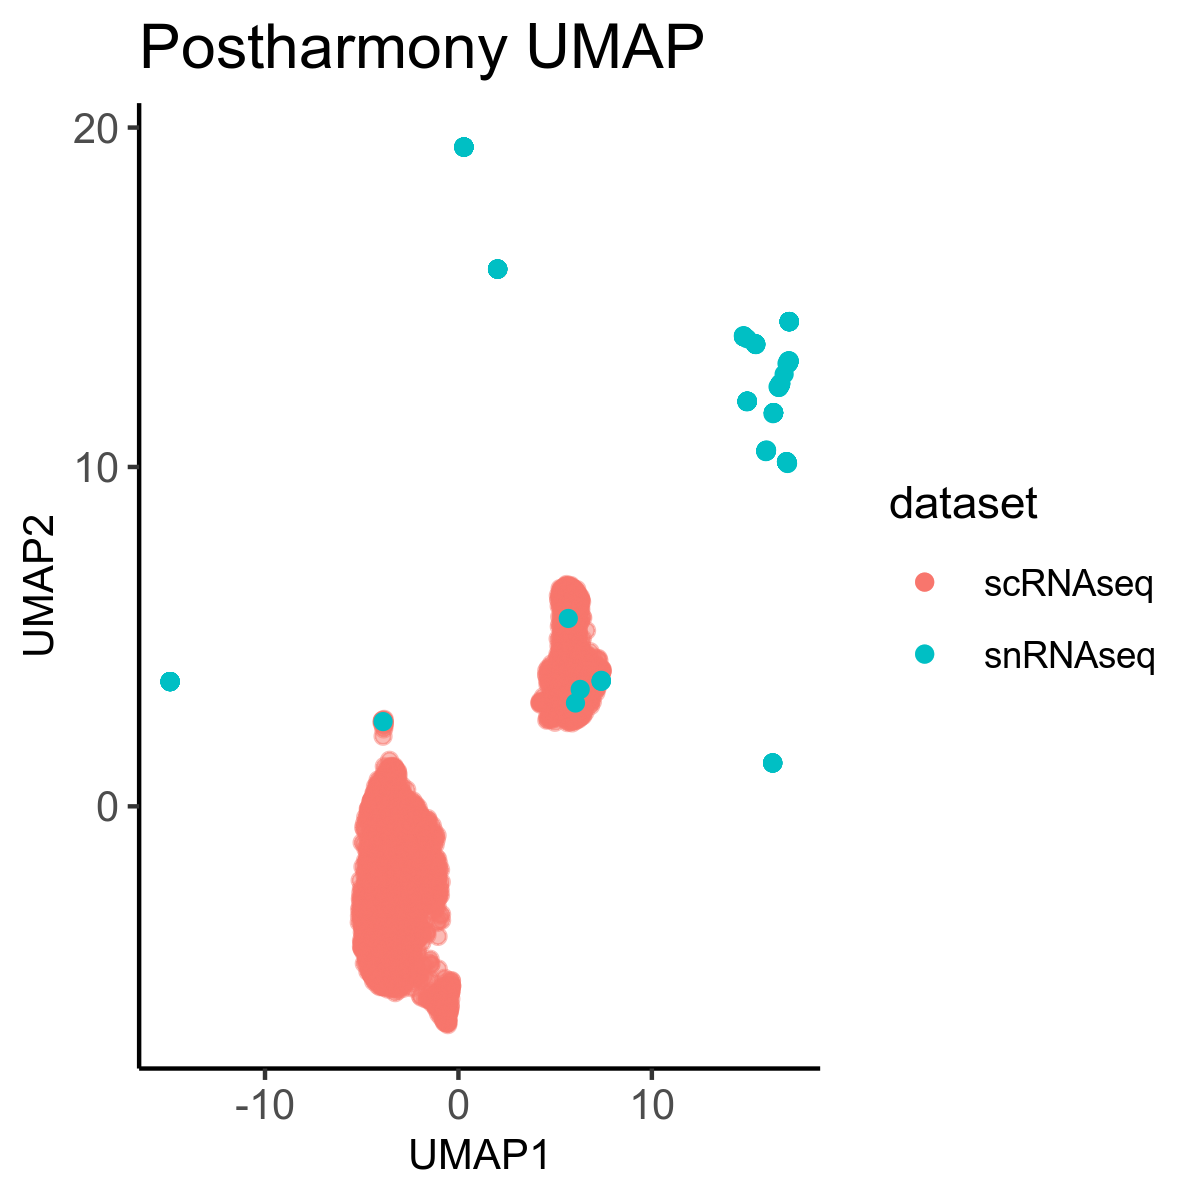

In [64]:
fig.size(4, 4)

df <- weighted_umap %>% data.frame() %>% mutate(dataset = qcd_meta$dataset)
df <- df[sample(nrow(df)), ]
ggplot(df, aes(x = X1, y = X2, color = dataset)) +
    geom_point(data = df %>% filter(dataset == 'scRNAseq'), alpha = 0.5, size = 1.5) +
    geom_point(data = df %>% filter(dataset == 'snRNAseq'), alpha = 2, size = 1.5) +
    theme_classic() + 
    theme(axis.text = element_text(size = 10), axis.title = element_text(size = 10), plot.title = element_text(size = 15)) +
    labs(title = 'Preharmony UMAP', x = 'UMAP1', y = 'UMAP2')

df <- harmony_umap2 %>% data.frame() %>% mutate(dataset = qcd_meta$dataset)
df <- df[sample(nrow(df)), ]
fig.size(4, 4)
ggplot(df, aes(x = X1, y = X2, color = dataset)) +
    geom_point(data = df %>% filter(dataset == 'scRNAseq'), alpha = 0.5, size = 1.5) +
    geom_point(data = df %>% filter(dataset == 'snRNAseq'), alpha = 2, size = 1.5) +
    theme_classic() + 
    theme(axis.text = element_text(size = 10), axis.title = element_text(size = 10), plot.title = element_text(size = 15)) +
    labs(title = 'Postharmony UMAP', x = 'UMAP1', y = 'UMAP2')

In [58]:
qcd_meta %>% filter(dataset == 'snRNAseq')

,UMAP1,UMAP2,cell,sample,Annot.separate,dataset,uwotUMAP1,uwotUMAP2,Site,Type,processing.batch,nCount_RNA,nFeature_RNA,broad.type,qc_cluster,doublet_score,doublet_classification
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<chr>
36135,-8.925204,4.366808,AGTGAGGCAATGTAAG-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.556252,-9.819888,Rochester,LN,35,4512,2561,T/NK,4,0.05851977,no
36140,-8.332296,3.970649,CATCAGAAGCCCTAAT-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.382548,-9.444645,Rochester,LN,35,1732,1307,T/NK,5,0.10310555,no
36144,-8.379827,4.183058,CGAGCCAGTCTAGTCA-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.562746,-9.825952,Rochester,LN,35,5905,3103,T/NK,0,0.07308470,no
36149,-8.557774,4.089571,CTGTTTATCACAGTAC-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.560684,-9.868097,Rochester,LN,35,7945,3658,T/NK,0,0.07308470,no
36150,-8.123601,4.049858,CTTAGGAAGCGATAGC-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.467880,-9.564364,Rochester,LN,35,2378,1749,T/NK,5,0.08420085,no
36154,-8.121324,3.987960,GATCTAGTCTCCAACC-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.534987,-9.706124,Rochester,LN,35,3124,2001,T/NK,0,0.06982296,no
36156,-8.302553,3.815916,GCAGCCACACCGGAAA-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.488497,-9.611729,Rochester,LN,35,1912,1427,T/NK,6,0.08420085,no
36162,-7.918616,4.072617,TCACAAGCAGGTCGTC-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.527067,-9.708569,Rochester,LN,35,2759,1866,T/NK,0,0.09784250,no
36168,-8.657862,4.428138,TTCTCAACAGGCTGAA-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.563570,-9.830641,Rochester,LN,35,3992,2326,T/NK,0,0.07308470,no
